In [ ]:
import matplotlib.pyplot as plt
from matplotlib import pyplot
import pandas as pd
import os
from tqdm import tqdm
from random import shuffle
import tensorflow as tf
import tensorflow_datasets as tfds
import keras.layers as kl
import numpy as np
import cv2
from tensorflow.keras import layers,regularizers
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from keras.layers import Input, Conv2D, MaxPooling2D, Dense, UpSampling2D, BatchNormalization,Flatten, Dropout,  Add, Concatenate,AveragePooling2D, ZeroPadding2D,Activation
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.models import load_model
import argparse
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.initializers import glorot_uniform


print(tf.__version__)

2.9.2


<a name='1'></a>
# Load Data


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -q /content/drive/MyDrive/NNproject/NNDataset.zip -d data

In [ ]:
dataset_path = '/content/data/Train' 
Test_path='/content/data/Test'
saved_dataset_path='/content/drive/MyDrive/NNproject/train_data.npy'
vgg16_weights_path='/content/drive/MyDrive/NNproject/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
resnet50_weights_path="/content/drive/MyDrive/NNproject/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5"
xception_weight_path="/content/drive/MyDrive/NNproject/xception_weights_tf_dim_ordering_tf_kernels_notop.h5"

In [ ]:
def create_label_in_binary(img_name):
  word_label = img_name.split('_')[0]
  if word_label == 'Basketball':
    return word_label,np.array([1, 0, 0, 0, 0, 0])
  if word_label == 'Football':
    return word_label,np.array([0, 1, 0, 0, 0, 0])
  if word_label == 'Rowing':
    return word_label,np.array([0, 0, 1, 0, 0, 0])
  if word_label == 'Swimming':
    return word_label,np.array([0, 0, 0, 1, 0, 0])
  if word_label == 'Tennis':
    return word_label,np.array([0, 0, 0, 0, 1, 0])
  if word_label == 'Yoga':
    return word_label,np.array([0, 0, 0, 0, 0, 1])
  else:
    return 'unknwon',np.array([0, 0, 0, 0, 0, 0])

In [ ]:
IMAGE_SIZE = 224
from scipy import fft
def create_dataset(path,IMAGE_SIZE=224):
  dataset = []
  dic={}
  for img in tqdm(os.listdir(path)):
    path = os.path.join(dataset_path, img)
    img_data = cv2.imread(path) # BGR IMAGE
    img_data = cv2.cvtColor(img_data, cv2.COLOR_BGR2RGB)
    img_data = cv2.resize(img_data, (IMAGE_SIZE, IMAGE_SIZE)) #new
    img_data=fft.dct(np.array(img_data))
    #print(img_data.shape)
    
    
    
    key,label=create_label_in_binary(img)
    if key not in dic.keys():
      dic[key]=[]
    dic[key].append([np.array(img_data),label ])
  return dic

In [ ]:
data=create_dataset(dataset_path)
for key in data.keys():
  print("num of "+key+" images "+str(len(data[key])))

100%|██████████| 1681/1681 [00:11<00:00, 143.39it/s]

num of Basketball images 196
num of Football images 400
num of Tennis images 185
num of Rowing images 202
num of Yoga images 458
num of Swimming images 240


<a name='2'></a>
# Train Validation split


In [ ]:
#split data train 80%, validation 20% per each class
train_data=[]
validation_data=[]
for key in data.keys():
  train, validation = np.split(data[key], [int(len(data[key])*0.8)]) 
  train_data.extend(train)
  validation_data.extend(validation)

  

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


In [ ]:
print(len(train_data))
print(len(validation_data))
shuffle(train_data)
shuffle(validation_data)

1343
338


In [ ]:

def resize_data(train_data,validation_data,IMAGE_SIZE):
    X_train = np.array([cv2.resize(i[0], (IMAGE_SIZE, IMAGE_SIZE)) for i in train_data]).reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 3) # -1 means take any num of data. 3 means RGB
    y_train = [i[1] for i in train_data]

    X_validation = np.array([cv2.resize(i[0], (IMAGE_SIZE, IMAGE_SIZE)) for i in validation_data]).reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 3) # -1 means take any num of data. 3 means RGB
    y_validation = [i[1] for i in validation_data]
    return X_train,y_train,X_validation,y_validation
X_train,y_train,X_validation,y_validation=resize_data(train_data,validation_data,224)   

In [ ]:
plt.title('Original image')
plt.imshow(np.squeeze(X_train[0]))
print(y_train[0])
print(X_train[0].shape)

<a name='3'></a>
# Preprocessing

In [ ]:
def img_normalized(img):
  img=img/255.0
  img-=0.5
  img*=2
  return img

In [ ]:
def increasing_image_sharpening(img):
  cv2.waitKey()
  cv2.destroyAllWindows()
  kernel = np.array([[0, -1, 0],
                    [-1, 5,-1],
                    [0, -1, 0]])
  image_sharp = cv2.filter2D(src=img, ddepth=-1, kernel=kernel)
  return image_sharp

In [ ]:
def preprocessing(X):
  newX=[]
  for imgs in X:
    img = increasing_image_sharpening(imgs)
    img = img_normalized(img)
    newX.append(img)
  return newX 

In [ ]:
def data_augmentation(img, img_label_in_binary):
  X_augmented_images = []
  y_augmented_images = []
  
  datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        fill_mode='nearest')
  
  img = np.expand_dims(img, 0)

  num_of_augmented_images = 2
  for i in range(num_of_augmented_images):
    it = datagen.flow(img, batch_size=1)
    batch = it.next()
    aug_image = batch[0].astype('uint8')
    X_augmented_images.append(np.array(aug_image))
    y_augmented_images.append(img_label_in_binary)

  return X_augmented_images, y_augmented_images

In [ ]:
from sklearn.utils import shuffle
X_augmented_images = []
y_augmented_images = []

for (img_data, img_label) in zip(X_train, y_train):
  images, labels = data_augmentation(img_data, img_label)
  images=preprocessing(images)
  X_augmented_images.extend(images)
  y_augmented_images.extend(labels)

data={'image':X_augmented_images,'label':y_augmented_images}
augmented_df=pd.DataFrame(data)
augmented_df = pd.DataFrame(shuffle(augmented_df, random_state=0))

[0 0 0 0 0 1]


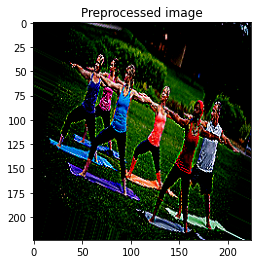

In [ ]:
plt.title('Preprocessed image')
plt.imshow(augmented_df.iloc[0,0])
print(augmented_df.iloc[0,1])

In [ ]:
nX_validation=preprocessing(X_validation)


<a name='4'></a>
# Build CNN models


<a name='4-1'></a>
> **VGG16**

In [ ]:
def VGG16():
    model = Sequential()
    model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu",name="input"))
    model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2),name='vgg16'))
    model.add(Flatten(name='flatten'))
    #model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu', name='fc1'))
    model.add(Dense(128, activation='relu', name='fc2'))
    model.add(Dense(6, activation='softmax', name='output'))
    return model
def vgg_model():
   model = VGG16()
   
   Vgg16 = Model(inputs=model.input, outputs=model.get_layer('vgg16').output)
   Vgg16.load_weights(vgg16_weights_path)
   for layer in Vgg16.layers: #to freeze top layers and tune nly the parameters of output layer
    layer.trainable = False
   #model.summary() 
   return model    

<a name='4-2'></a>
> **googlenet_resnet**

In [ ]:
CLASS_NUM = 6
BATCH_SIZE = 16

IMAGE_SHAPE = (224, 224, 3)
MODEL_NAME = 'googlenet_resnet'


def inception(x, filters):
    # 1x1
    path1 = Conv2D(filters=filters[0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(x)

    # 1x1->3x3
    path2 = Conv2D(filters=filters[1][0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(x)
    path2 = Conv2D(filters=filters[1][1], kernel_size=(3,3), strides=1, padding='same', activation='relu')(path2)
    
    # 1x1->5x5
    path3 = Conv2D(filters=filters[2][0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(x)
    path3 = Conv2D(filters=filters[2][1], kernel_size=(5,5), strides=1, padding='same', activation='relu')(path3)

    # 3x3->1x1
    path4 = MaxPooling2D(pool_size=(3,3), strides=1, padding='same')(x)
    path4 = Conv2D(filters=filters[3], kernel_size=(1,1), strides=1, padding='same', activation='relu')(path4)

    return Concatenate(axis=-1)([path1,path2,path3,path4])


def auxiliary(x, name=None):
    layer = AveragePooling2D(pool_size=(5,5), strides=3, padding='valid')(x)
    layer = Conv2D(filters=128, kernel_size=(1,1), strides=1, padding='same', activation='relu')(layer)
    layer = Flatten()(layer)
    layer = Dense(units=256, activation='relu')(layer)
    layer = Dropout(0.4)(layer)
    layer = Dense(units=CLASS_NUM, activation='softmax', name=name)(layer)
    return layer


def googlenet():
    layer_in = Input(shape=IMAGE_SHAPE)
    
    # stage-1
    layer = Conv2D(filters=64, kernel_size=(7,7), strides=2, padding='same', activation='relu')(layer_in)
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)
    layer = BatchNormalization()(layer)

    # stage-2
    layer = Conv2D(filters=64, kernel_size=(1,1), strides=1, padding='same', activation='relu')(layer)
    layer = Conv2D(filters=192, kernel_size=(3,3), strides=1, padding='same', activation='relu')(layer)
    layer = BatchNormalization()(layer)
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)

    # stage-3
   
    layer = inception(layer, [ 64,  (96,128), (16,32), 32]) #3a
   

    layer = inception(layer, [128, (128,192), (32,96), 64]) #3b
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)
    
    # stage-4
   
    layer = inception(layer, [192,  (96,208),  (16,48),  64]) #4a
    aux1  = auxiliary(layer, name='aux1')

   
    layer = inception(layer, [160, (112,224),  (24,64),  64]) #4b
  

    
    layer = inception(layer, [128, (128,256),  (24,64),  64]) #4c
   

   
    layer = inception(layer, [112, (144,288),  (32,64),  64]) #4d
    aux2  = auxiliary(layer, name='aux2')

  
    layer = inception(layer, [256, (160,320), (32,128), 128]) #4e
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)
    
    # stage-5
   
    layer = inception(layer, [256, (160,320), (32,128), 128]) #5a
    
    
 
    layer = inception(layer, [384, (192,384), (48,128), 128]) #5b
    layer = AveragePooling2D(pool_size=(7,7), strides=1, padding='valid')(layer)
    
    # stage-6
    layer = Flatten()(layer)
    layer = Dropout(0.4)(layer)
    layer = Dense(units=256, activation='linear')(layer)
    main = Dense(units=CLASS_NUM, activation='softmax', name='main')(layer)
    
    model = Model(inputs=layer_in, outputs=[main, aux1, aux2])
    #model.summary()
    return model

<a name='4-3'></a>
> **Resnet50**

In [ ]:
def identity_block(X, f, filters, stage, block):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters

    X_shortcut = X
   
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X = Add()([X, X_shortcut])# SKIP Connection
    X = Activation('relu')(X)

    return X

In [ ]:
def convolutional_block(X, f, filters, stage, block, s=2):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [ ]:
def ResNet50(input_shape=(224, 224, 3)):

    X_input = Input(input_shape)

    X = ZeroPadding2D((3, 3))(X_input)

    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')


    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    X = X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)
    
    model = Model(inputs=X_input, outputs=X, name='ResNet50')

    return model
def Pretrained_Resnet50():
  base_model = ResNet50(input_shape=(224, 224, 3))
  top_layer = base_model.output
  top_layer = Flatten()(top_layer)
  top_layer=Dense(256, activation='relu', name='fc1',kernel_initializer=glorot_uniform(seed=0))(top_layer)
  #top_layer=Dropout(0.5)(top_layer)
  top_layer=Dense(128, activation='relu', name='fc2',kernel_initializer=glorot_uniform(seed=0))(top_layer)
  top_layer = Dense( 6,activation='softmax', name='fc3',kernel_initializer=glorot_uniform(seed=0))(top_layer)   

  #load pretraind weights 
  base_model.load_weights(resnet50_weights_path) 
  model = Model(inputs=base_model.input, outputs=top_layer)

  #frezzing layers of base model

  for layer in base_model.layers:
    layer.trainable = False
    
 
  #model.summary()
  return model  
#Pretrained_Resnet50() 



> Xception model



In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input,Dense,Conv2D,Add
from tensorflow.keras.layers import SeparableConv2D,ReLU
from tensorflow.keras.layers import BatchNormalization,MaxPool2D
from tensorflow.keras.layers import GlobalAvgPool2D
from tensorflow.keras import Model


def xception():
    input = Input(shape = (229,229,3))
    x = Conv2D(32, (3, 3), strides=(2, 2), use_bias=False, name='block1_conv1')(input)
    x = BatchNormalization(name='block1_conv1_bn')(x)
    x = Activation('relu', name='block1_conv1_act')(x)
    x = Conv2D(64, (3, 3), use_bias=False, name='block1_conv2')(x)
    x = BatchNormalization(name='block1_conv2_bn')(x)
    x = Activation('relu', name='block1_conv2_act')(x)

    residual = Conv2D(128, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(128, (3, 3), padding='same', use_bias=False, name='block2_sepconv1')(x)
    x = BatchNormalization(name='block2_sepconv1_bn')(x)
    x = Activation('relu', name='block2_sepconv2_act')(x)
    x = SeparableConv2D(128, (3, 3), padding='same', use_bias=False, name='block2_sepconv2')(x)
    x = BatchNormalization(name='block2_sepconv2_bn')(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='block2_pool')(x)
    x = layers.add([x, residual])

    residual = Conv2D(256, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = Activation('relu', name='block3_sepconv1_act')(x)
    x = SeparableConv2D(256, (3, 3), padding='same', use_bias=False, name='block3_sepconv1')(x)
    x = BatchNormalization(name='block3_sepconv1_bn')(x)
    x = Activation('relu', name='block3_sepconv2_act')(x)
    x = SeparableConv2D(256, (3, 3), padding='same', use_bias=False, name='block3_sepconv2')(x)
    x = BatchNormalization(name='block3_sepconv2_bn')(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='block3_pool')(x)
    x = layers.add([x, residual])

    residual = Conv2D(728, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = Activation('relu', name='block4_sepconv1_act')(x)
    x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name='block4_sepconv1')(x)
    x = BatchNormalization(name='block4_sepconv1_bn')(x)
    x = Activation('relu', name='block4_sepconv2_act')(x)
    x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name='block4_sepconv2')(x)
    x = BatchNormalization(name='block4_sepconv2_bn')(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='block4_pool')(x)
    x = layers.add([x, residual])

    for i in range(8):
        residual = x
        prefix = 'block' + str(i + 5)

        x = Activation('relu', name=prefix + '_sepconv1_act')(x)
        x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name=prefix + '_sepconv1')(x)
        x = BatchNormalization(name=prefix + '_sepconv1_bn')(x)
        x = Activation('relu', name=prefix + '_sepconv2_act')(x)
        x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name=prefix + '_sepconv2')(x)
        x = BatchNormalization(name=prefix + '_sepconv2_bn')(x)
        x = Activation('relu', name=prefix + '_sepconv3_act')(x)
        x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name=prefix + '_sepconv3')(x)
        x = BatchNormalization(name=prefix + '_sepconv3_bn')(x)

        x = layers.add([x, residual])

    residual = Conv2D(1024, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = Activation('relu', name='block13_sepconv1_act')(x)
    x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name='block13_sepconv1')(x)
    x = BatchNormalization(name='block13_sepconv1_bn')(x)
    x = Activation('relu', name='block13_sepconv2_act')(x)
    x = SeparableConv2D(1024, (3, 3), padding='same', use_bias=False, name='block13_sepconv2')(x)
    x = BatchNormalization(name='block13_sepconv2_bn')(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='block13_pool')(x)
    x = layers.add([x, residual])

    x = SeparableConv2D(1536, (3, 3), padding='same', use_bias=False, name='block14_sepconv1')(x)
    x = BatchNormalization(name='block14_sepconv1_bn')(x)
    x = Activation('relu', name='block14_sepconv1_act')(x)

    x = SeparableConv2D(2048, (3, 3), padding='same', use_bias=False, name='block14_sepconv2')(x)
    x = BatchNormalization(name='block14_sepconv2_bn')(x)
    x = Activation('relu', name='block14_sepconv2_act')(x)
    base_model = Model (inputs=input, outputs=x)
    top_layer = base_model.output
    # top_layer = GlobalAvgPool2D()(top_layer)
    top_layer = Flatten()(top_layer)
    top_layer = Dense(256, activation='relu', name='fc1')(top_layer)
    #top_layer = Dropout(0.5)(top_layer)
    top_layer = Dense(128, activation='relu', name='fc2')(top_layer)
    top_layer = Dense (units = 6, activation = 'softmax')(top_layer)   

  #load pretraind weights 
    base_model.load_weights(xception_weight_path) 
    model = Model(inputs=base_model.input, outputs=top_layer)
     #frezzing layers of base model
    for layer in base_model.layers:
       layer.trainable = False
   
   
    model.summary()
    return model
   
# xception()    

<a name='5'></a>
# Train CNN models

In [ ]:
#best model
X_train_xception,y_train_xception,X_valid_xception,y_valid_xception=resize_data(train_data,validation_data,229) 
X_train_xception=img_normalized(X_train_xception)
X_valid_xception=img_normalized(X_valid_xception)

X_train_xception = np.asarray(X_train_xception).astype(np.float32)
y_train_xception = np.asarray(y_train_xception).astype(np.float32)
X_valid_xception = np.asarray(X_valid_xception).astype(np.float32)
y_valid_xception = np.asarray(y_valid_xception).astype(np.float32)

Xception=xception()
Xception.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=1e-3),metrics=["accuracy"])
mc = ModelCheckpoint('/content/drive/MyDrive/NNproject/xception.h5',monitor='val_accuracy', mode='max')
Xception.fit(X_train_xception,  y_train_xception,validation_data=( X_valid_xception,  y_valid_xception),epochs=5,verbose=1,callbacks=[mc],shuffle=True )

In [ ]:
def model_train(model,X_train,y_train,x_valid,y_valid,name_of_model,lr=1e-3):

   if name_of_model =="googlenet_1":
     model.compile(loss='categorical_crossentropy', 
                  loss_weights={'main': 1.0, 'aux1': 0.3, 'aux2': 0.3},
                  optimizer=Adam(learning_rate=lr),metrics = ["accuracy"])
   else:
      model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=lr),metrics=["accuracy"])

   es=EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10)
   mc = ModelCheckpoint('/content/drive/MyDrive/NNproject/'+name_of_model+'.h5', monitor='val_accuracy', mode='max', save_best_only=True)

   fitModel = model.fit(X_train,  y_train,validation_data=( x_valid,  y_valid),epochs=100,verbose=1,callbacks=[es],shuffle=True )
   return model

In [ ]:
#X_train,y_train,X_validation,y_validation
x_train = np.asarray(X_train).astype(np.float32)
Y_train = np.asarray(y_train).astype(np.float32)
x_validation = np.asarray(X_validation).astype(np.float32)
Y_validation = np.asarray(y_validation).astype(np.float32)

In [ ]:
resnet50=Pretrained_Resnet50()
resnet50=model_train(resnet50,x_train,Y_train,x_validation,Y_validation,"resnet50_1",lr=1e-2)

Epoch 1/100
42/42 [==============================] - 20s 174ms/step - loss: 183.2970 - accuracy: 0.3812 - val_loss: 7.3933 - val_accuracy: 0.5266
Epoch 2/100
42/42 [==============================] - 5s 118ms/step - loss: 2.3908 - accuracy: 0.6195 - val_loss: 1.4887 - val_accuracy: 0.5976
Epoch 3/100
42/42 [==============================] - 5s 118ms/step - loss: 1.0085 - accuracy: 0.6902 - val_loss: 0.9742 - val_accuracy: 0.6391
Epoch 4/100
42/42 [==============================] - 5s 126ms/step - loss: 0.6874 - accuracy: 0.7729 - val_loss: 0.8473 - val_accuracy: 0.7337
Epoch 5/100
42/42 [==============================] - 5s 121ms/step - loss: 0.5376 - accuracy: 0.8191 - val_loss: 0.8530 - val_accuracy: 0.7692
Epoch 6/100
42/42 [==============================] - 5s 124ms/step - loss: 0.5073 - accuracy: 0.8235 - val_loss: 1.3470 - val_accuracy: 0.7012
Epoch 7/100
42/42 [==============================] - 5s 121ms/step - loss: 0.5633 - accuracy: 0.8459 - val_loss: 1.1997 - val_accuracy: 0.6

In [ ]:
googlenet_1 = googlenet()
googlenet_1=model_train(googlenet_1,x_train,Y_train,x_validation,Y_validation,"googlenet_1")

Epoch 1/100
84/84 [==============================] - ETA: 0s - loss: 2.1332 - main_loss: 1.3883 - aux1_loss: 1.1975 - aux2_loss: 1.2855 - main_accuracy: 0.5134 - aux1_accuracy: 0.5618 - aux2_accuracy: 0.5208

84/84 [==============================] - 31s 188ms/step - loss: 2.1332 - main_loss: 1.3883 - aux1_loss: 1.1975 - aux2_loss: 1.2855 - main_accuracy: 0.5134 - aux1_accuracy: 0.5618 - aux2_accuracy: 0.5208 - val_loss: 2.3198 - val_main_loss: 1.5059 - val_aux1_loss: 1.3267 - val_aux2_loss: 1.3866 - val_main_accuracy: 0.4320 - val_aux1_accuracy: 0.5680 - val_aux2_accuracy: 0.4941
Epoch 2/100
84/84 [==============================] - ETA: 0s - loss: 1.5332 - main_loss: 0.9893 - aux1_loss: 0.8720 - aux2_loss: 0.9409 - main_accuracy: 0.6571 - aux1_accuracy: 0.6858 - aux2_accuracy: 0.6783

84/84 [==============================] - 11s 131ms/step - loss: 1.5332 - main_loss: 0.9893 - aux1_loss: 0.8720 - aux2_loss: 0.9409 - main_accuracy: 0.6571 - aux1_accuracy: 0.6858 - aux2_accuracy: 0.6783 - val_loss: 1.8621 - val_main_loss: 1.2122 - val_aux1_loss: 1.0210 - val_aux2_loss: 1.1454 - val_main_accuracy: 0.5917 - val_aux1_accuracy: 0.6775 - val_aux2_accuracy: 0.6154
Epoch 3/100
84/84 [==============================] - ETA: 0s - loss: 1.4007 - main_loss: 0.9117 - aux1_loss: 0.7679 - aux2_loss: 0.8621 - main_accuracy: 0.6962 - aux1_accuracy: 0.7319 - aux2_accuracy: 0.7014

84/84 [==============================] - 12s 142ms/step - loss: 1.4007 - main_loss: 0.9117 - aux1_loss: 0.7679 - aux2_loss: 0.8621 - main_accuracy: 0.6962 - aux1_accuracy: 0.7319 - aux2_accuracy: 0.7014 - val_loss: 1.2738 - val_main_loss: 0.8281 - val_aux1_loss: 0.7031 - val_aux2_loss: 0.7824 - val_main_accuracy: 0.7130 - val_aux1_accuracy: 0.7722 - val_aux2_accuracy: 0.7219
Epoch 4/100
84/84 [==============================] - ETA: 0s - loss: 1.2003 - main_loss: 0.7754 - aux1_loss: 0.6762 - aux2_loss: 0.7399 - main_accuracy: 0.7360 - aux1_accuracy: 0.7666 - aux2_accuracy: 0.7394

84/84 [==============================] - 11s 131ms/step - loss: 1.2003 - main_loss: 0.7754 - aux1_loss: 0.6762 - aux2_loss: 0.7399 - main_accuracy: 0.7360 - aux1_accuracy: 0.7666 - aux2_accuracy: 0.7394 - val_loss: 1.1231 - val_main_loss: 0.7151 - val_aux1_loss: 0.6591 - val_aux2_loss: 0.7010 - val_main_accuracy: 0.7899 - val_aux1_accuracy: 0.7692 - val_aux2_accuracy: 0.7633
Epoch 5/100
84/84 [==============================] - ETA: 0s - loss: 1.1078 - main_loss: 0.7282 - aux1_loss: 0.5969 - aux2_loss: 0.6682 - main_accuracy: 0.7606 - aux1_accuracy: 0.7982 - aux2_accuracy: 0.7759

84/84 [==============================] - 11s 128ms/step - loss: 1.1078 - main_loss: 0.7282 - aux1_loss: 0.5969 - aux2_loss: 0.6682 - main_accuracy: 0.7606 - aux1_accuracy: 0.7982 - aux2_accuracy: 0.7759 - val_loss: 1.1960 - val_main_loss: 0.7644 - val_aux1_loss: 0.6985 - val_aux2_loss: 0.7403 - val_main_accuracy: 0.7663 - val_aux1_accuracy: 0.7544 - val_aux2_accuracy: 0.7426
Epoch 6/100
84/84 [==============================] - ETA: 0s - loss: 0.9818 - main_loss: 0.6437 - aux1_loss: 0.5244 - aux2_loss: 0.6024 - main_accuracy: 0.7822 - aux1_accuracy: 0.8168 - aux2_accuracy: 0.7867

84/84 [==============================] - 11s 128ms/step - loss: 0.9818 - main_loss: 0.6437 - aux1_loss: 0.5244 - aux2_loss: 0.6024 - main_accuracy: 0.7822 - aux1_accuracy: 0.8168 - aux2_accuracy: 0.7867 - val_loss: 1.1141 - val_main_loss: 0.6743 - val_aux1_loss: 0.7166 - val_aux2_loss: 0.7493 - val_main_accuracy: 0.7751 - val_aux1_accuracy: 0.7663 - val_aux2_accuracy: 0.7574
Epoch 7/100
84/84 [==============================] - ETA: 0s - loss: 0.9090 - main_loss: 0.5956 - aux1_loss: 0.4908 - aux2_loss: 0.5538 - main_accuracy: 0.8086 - aux1_accuracy: 0.8321 - aux2_accuracy: 0.8120

84/84 [==============================] - 11s 128ms/step - loss: 0.9090 - main_loss: 0.5956 - aux1_loss: 0.4908 - aux2_loss: 0.5538 - main_accuracy: 0.8086 - aux1_accuracy: 0.8321 - aux2_accuracy: 0.8120 - val_loss: 0.9412 - val_main_loss: 0.6079 - val_aux1_loss: 0.5310 - val_aux2_loss: 0.5799 - val_main_accuracy: 0.8107 - val_aux1_accuracy: 0.8373 - val_aux2_accuracy: 0.8254
Epoch 8/100
84/84 [==============================] - ETA: 0s - loss: 0.8490 - main_loss: 0.5612 - aux1_loss: 0.4404 - aux2_loss: 0.5188 - main_accuracy: 0.8157 - aux1_accuracy: 0.8488 - aux2_accuracy: 0.8273

84/84 [==============================] - 11s 128ms/step - loss: 0.8490 - main_loss: 0.5612 - aux1_loss: 0.4404 - aux2_loss: 0.5188 - main_accuracy: 0.8157 - aux1_accuracy: 0.8488 - aux2_accuracy: 0.8273 - val_loss: 0.9215 - val_main_loss: 0.6070 - val_aux1_loss: 0.5041 - val_aux2_loss: 0.5444 - val_main_accuracy: 0.7988 - val_aux1_accuracy: 0.8284 - val_aux2_accuracy: 0.8284
Epoch 9/100
84/84 [==============================] - ETA: 0s - loss: 0.8157 - main_loss: 0.5505 - aux1_loss: 0.3897 - aux2_loss: 0.4946 - main_accuracy: 0.8179 - aux1_accuracy: 0.8641 - aux2_accuracy: 0.8328

84/84 [==============================] - 11s 130ms/step - loss: 0.8157 - main_loss: 0.5505 - aux1_loss: 0.3897 - aux2_loss: 0.4946 - main_accuracy: 0.8179 - aux1_accuracy: 0.8641 - aux2_accuracy: 0.8328 - val_loss: 1.1607 - val_main_loss: 0.7661 - val_aux1_loss: 0.6445 - val_aux2_loss: 0.6710 - val_main_accuracy: 0.7781 - val_aux1_accuracy: 0.7899 - val_aux2_accuracy: 0.7811
Epoch 10/100
84/84 [==============================] - ETA: 0s - loss: 0.6993 - main_loss: 0.4668 - aux1_loss: 0.3602 - aux2_loss: 0.4146 - main_accuracy: 0.8399 - aux1_accuracy: 0.8697 - aux2_accuracy: 0.8567

84/84 [==============================] - 11s 128ms/step - loss: 0.6993 - main_loss: 0.4668 - aux1_loss: 0.3602 - aux2_loss: 0.4146 - main_accuracy: 0.8399 - aux1_accuracy: 0.8697 - aux2_accuracy: 0.8567 - val_loss: 0.9288 - val_main_loss: 0.6082 - val_aux1_loss: 0.5261 - val_aux2_loss: 0.5426 - val_main_accuracy: 0.8254 - val_aux1_accuracy: 0.8491 - val_aux2_accuracy: 0.8373
Epoch 11/100
84/84 [==============================] - ETA: 0s - loss: 0.6698 - main_loss: 0.4513 - aux1_loss: 0.3314 - aux2_loss: 0.3970 - main_accuracy: 0.8511 - aux1_accuracy: 0.8868 - aux2_accuracy: 0.8693

84/84 [==============================] - 11s 128ms/step - loss: 0.6698 - main_loss: 0.4513 - aux1_loss: 0.3314 - aux2_loss: 0.3970 - main_accuracy: 0.8511 - aux1_accuracy: 0.8868 - aux2_accuracy: 0.8693 - val_loss: 0.9144 - val_main_loss: 0.5692 - val_aux1_loss: 0.5826 - val_aux2_loss: 0.5679 - val_main_accuracy: 0.8254 - val_aux1_accuracy: 0.8136 - val_aux2_accuracy: 0.8284
Epoch 12/100
84/84 [==============================] - ETA: 0s - loss: 0.7080 - main_loss: 0.4746 - aux1_loss: 0.3454 - aux2_loss: 0.4325 - main_accuracy: 0.8317 - aux1_accuracy: 0.8820 - aux2_accuracy: 0.8470

84/84 [==============================] - 11s 128ms/step - loss: 0.7080 - main_loss: 0.4746 - aux1_loss: 0.3454 - aux2_loss: 0.4325 - main_accuracy: 0.8317 - aux1_accuracy: 0.8820 - aux2_accuracy: 0.8470 - val_loss: 0.9430 - val_main_loss: 0.5919 - val_aux1_loss: 0.5849 - val_aux2_loss: 0.5857 - val_main_accuracy: 0.8047 - val_aux1_accuracy: 0.8284 - val_aux2_accuracy: 0.8284
Epoch 13/100
84/84 [==============================] - ETA: 0s - loss: 0.6252 - main_loss: 0.4224 - aux1_loss: 0.2992 - aux2_loss: 0.3765 - main_accuracy: 0.8582 - aux1_accuracy: 0.8961 - aux2_accuracy: 0.8790

84/84 [==============================] - 11s 128ms/step - loss: 0.6252 - main_loss: 0.4224 - aux1_loss: 0.2992 - aux2_loss: 0.3765 - main_accuracy: 0.8582 - aux1_accuracy: 0.8961 - aux2_accuracy: 0.8790 - val_loss: 1.0462 - val_main_loss: 0.6773 - val_aux1_loss: 0.5721 - val_aux2_loss: 0.6579 - val_main_accuracy: 0.7959 - val_aux1_accuracy: 0.8462 - val_aux2_accuracy: 0.8314
Epoch 14/100
84/84 [==============================] - ETA: 0s - loss: 0.5509 - main_loss: 0.3742 - aux1_loss: 0.2671 - aux2_loss: 0.3220 - main_accuracy: 0.8730 - aux1_accuracy: 0.9088 - aux2_accuracy: 0.8909

84/84 [==============================] - 11s 128ms/step - loss: 0.5509 - main_loss: 0.3742 - aux1_loss: 0.2671 - aux2_loss: 0.3220 - main_accuracy: 0.8730 - aux1_accuracy: 0.9088 - aux2_accuracy: 0.8909 - val_loss: 0.9354 - val_main_loss: 0.5796 - val_aux1_loss: 0.5872 - val_aux2_loss: 0.5986 - val_main_accuracy: 0.8107 - val_aux1_accuracy: 0.8077 - val_aux2_accuracy: 0.8195
Epoch 15/100
84/84 [==============================] - ETA: 0s - loss: 0.4626 - main_loss: 0.3149 - aux1_loss: 0.2166 - aux2_loss: 0.2755 - main_accuracy: 0.8909 - aux1_accuracy: 0.9278 - aux2_accuracy: 0.9088

84/84 [==============================] - 11s 128ms/step - loss: 0.4626 - main_loss: 0.3149 - aux1_loss: 0.2166 - aux2_loss: 0.2755 - main_accuracy: 0.8909 - aux1_accuracy: 0.9278 - aux2_accuracy: 0.9088 - val_loss: 0.9829 - val_main_loss: 0.6410 - val_aux1_loss: 0.5152 - val_aux2_loss: 0.6248 - val_main_accuracy: 0.8077 - val_aux1_accuracy: 0.8373 - val_aux2_accuracy: 0.8284
Epoch 16/100
84/84 [==============================] - ETA: 0s - loss: 0.4314 - main_loss: 0.2947 - aux1_loss: 0.2040 - aux2_loss: 0.2516 - main_accuracy: 0.9002 - aux1_accuracy: 0.9356 - aux2_accuracy: 0.9170

84/84 [==============================] - 11s 128ms/step - loss: 0.4314 - main_loss: 0.2947 - aux1_loss: 0.2040 - aux2_loss: 0.2516 - main_accuracy: 0.9002 - aux1_accuracy: 0.9356 - aux2_accuracy: 0.9170 - val_loss: 1.1130 - val_main_loss: 0.6969 - val_aux1_loss: 0.7215 - val_aux2_loss: 0.6656 - val_main_accuracy: 0.8107 - val_aux1_accuracy: 0.8225 - val_aux2_accuracy: 0.8254
Epoch 17/100
84/84 [==============================] - ETA: 0s - loss: 0.4568 - main_loss: 0.3158 - aux1_loss: 0.2016 - aux2_loss: 0.2683 - main_accuracy: 0.8984 - aux1_accuracy: 0.9289 - aux2_accuracy: 0.9144

84/84 [==============================] - 11s 128ms/step - loss: 0.4568 - main_loss: 0.3158 - aux1_loss: 0.2016 - aux2_loss: 0.2683 - main_accuracy: 0.8984 - aux1_accuracy: 0.9289 - aux2_accuracy: 0.9144 - val_loss: 1.0675 - val_main_loss: 0.6881 - val_aux1_loss: 0.5806 - val_aux2_loss: 0.6844 - val_main_accuracy: 0.8077 - val_aux1_accuracy: 0.8195 - val_aux2_accuracy: 0.8166
Epoch 18/100
84/84 [==============================] - ETA: 0s - loss: 0.3457 - main_loss: 0.2456 - aux1_loss: 0.1308 - aux2_loss: 0.2029 - main_accuracy: 0.9207 - aux1_accuracy: 0.9538 - aux2_accuracy: 0.9293

84/84 [==============================] - 11s 128ms/step - loss: 0.3457 - main_loss: 0.2456 - aux1_loss: 0.1308 - aux2_loss: 0.2029 - main_accuracy: 0.9207 - aux1_accuracy: 0.9538 - aux2_accuracy: 0.9293 - val_loss: 0.7802 - val_main_loss: 0.4914 - val_aux1_loss: 0.5017 - val_aux2_loss: 0.4609 - val_main_accuracy: 0.8550 - val_aux1_accuracy: 0.8432 - val_aux2_accuracy: 0.8669
Epoch 19/100
84/84 [==============================] - ETA: 0s - loss: 0.3584 - main_loss: 0.2456 - aux1_loss: 0.1598 - aux2_loss: 0.2163 - main_accuracy: 0.9203 - aux1_accuracy: 0.9464 - aux2_accuracy: 0.9293

84/84 [==============================] - 11s 128ms/step - loss: 0.3584 - main_loss: 0.2456 - aux1_loss: 0.1598 - aux2_loss: 0.2163 - main_accuracy: 0.9203 - aux1_accuracy: 0.9464 - aux2_accuracy: 0.9293 - val_loss: 1.4521 - val_main_loss: 0.9261 - val_aux1_loss: 0.8033 - val_aux2_loss: 0.9500 - val_main_accuracy: 0.7988 - val_aux1_accuracy: 0.8107 - val_aux2_accuracy: 0.8018
Epoch 20/100
84/84 [==============================] - ETA: 0s - loss: 0.3551 - main_loss: 0.2491 - aux1_loss: 0.1421 - aux2_loss: 0.2115 - main_accuracy: 0.9207 - aux1_accuracy: 0.9509 - aux2_accuracy: 0.9311

84/84 [==============================] - 11s 128ms/step - loss: 0.3551 - main_loss: 0.2491 - aux1_loss: 0.1421 - aux2_loss: 0.2115 - main_accuracy: 0.9207 - aux1_accuracy: 0.9509 - aux2_accuracy: 0.9311 - val_loss: 0.8506 - val_main_loss: 0.5419 - val_aux1_loss: 0.4606 - val_aux2_loss: 0.5687 - val_main_accuracy: 0.8550 - val_aux1_accuracy: 0.8698 - val_aux2_accuracy: 0.8491
Epoch 21/100
84/84 [==============================] - ETA: 0s - loss: 0.3241 - main_loss: 0.2301 - aux1_loss: 0.1244 - aux2_loss: 0.1888 - main_accuracy: 0.9233 - aux1_accuracy: 0.9613 - aux2_accuracy: 0.9345

84/84 [==============================] - 11s 128ms/step - loss: 0.3241 - main_loss: 0.2301 - aux1_loss: 0.1244 - aux2_loss: 0.1888 - main_accuracy: 0.9233 - aux1_accuracy: 0.9613 - aux2_accuracy: 0.9345 - val_loss: 1.2828 - val_main_loss: 0.7894 - val_aux1_loss: 0.8156 - val_aux2_loss: 0.8291 - val_main_accuracy: 0.8225 - val_aux1_accuracy: 0.8225 - val_aux2_accuracy: 0.8284
Epoch 22/100
84/84 [==============================] - ETA: 0s - loss: 0.3805 - main_loss: 0.2628 - aux1_loss: 0.1599 - aux2_loss: 0.2325 - main_accuracy: 0.9214 - aux1_accuracy: 0.9483 - aux2_accuracy: 0.9330

84/84 [==============================] - 11s 128ms/step - loss: 0.3805 - main_loss: 0.2628 - aux1_loss: 0.1599 - aux2_loss: 0.2325 - main_accuracy: 0.9214 - aux1_accuracy: 0.9483 - aux2_accuracy: 0.9330 - val_loss: 0.8945 - val_main_loss: 0.5841 - val_aux1_loss: 0.4878 - val_aux2_loss: 0.5468 - val_main_accuracy: 0.8402 - val_aux1_accuracy: 0.8432 - val_aux2_accuracy: 0.8491
Epoch 23/100
84/84 [==============================] - ETA: 0s - loss: 0.2249 - main_loss: 0.1609 - aux1_loss: 0.0846 - aux2_loss: 0.1287 - main_accuracy: 0.9471 - aux1_accuracy: 0.9698 - aux2_accuracy: 0.9602

84/84 [==============================] - 11s 129ms/step - loss: 0.2249 - main_loss: 0.1609 - aux1_loss: 0.0846 - aux2_loss: 0.1287 - main_accuracy: 0.9471 - aux1_accuracy: 0.9698 - aux2_accuracy: 0.9602 - val_loss: 1.3255 - val_main_loss: 0.8086 - val_aux1_loss: 0.8345 - val_aux2_loss: 0.8885 - val_main_accuracy: 0.8402 - val_aux1_accuracy: 0.8343 - val_aux2_accuracy: 0.8284
Epoch 24/100
84/84 [==============================] - ETA: 0s - loss: 0.2649 - main_loss: 0.1880 - aux1_loss: 0.0994 - aux2_loss: 0.1571 - main_accuracy: 0.9393 - aux1_accuracy: 0.9676 - aux2_accuracy: 0.9464

84/84 [==============================] - 11s 128ms/step - loss: 0.2649 - main_loss: 0.1880 - aux1_loss: 0.0994 - aux2_loss: 0.1571 - main_accuracy: 0.9393 - aux1_accuracy: 0.9676 - aux2_accuracy: 0.9464 - val_loss: 0.8545 - val_main_loss: 0.5258 - val_aux1_loss: 0.5520 - val_aux2_loss: 0.5436 - val_main_accuracy: 0.8580 - val_aux1_accuracy: 0.8462 - val_aux2_accuracy: 0.8609
Epoch 25/100
84/84 [==============================] - ETA: 0s - loss: 0.2174 - main_loss: 0.1533 - aux1_loss: 0.0885 - aux2_loss: 0.1250 - main_accuracy: 0.9512 - aux1_accuracy: 0.9713 - aux2_accuracy: 0.9553

84/84 [==============================] - 11s 128ms/step - loss: 0.2174 - main_loss: 0.1533 - aux1_loss: 0.0885 - aux2_loss: 0.1250 - main_accuracy: 0.9512 - aux1_accuracy: 0.9713 - aux2_accuracy: 0.9553 - val_loss: 1.0509 - val_main_loss: 0.6391 - val_aux1_loss: 0.6579 - val_aux2_loss: 0.7147 - val_main_accuracy: 0.8284 - val_aux1_accuracy: 0.8609 - val_aux2_accuracy: 0.8432
Epoch 26/100
84/84 [==============================] - ETA: 0s - loss: 0.2500 - main_loss: 0.1783 - aux1_loss: 0.0977 - aux2_loss: 0.1412 - main_accuracy: 0.9419 - aux1_accuracy: 0.9684 - aux2_accuracy: 0.9520

84/84 [==============================] - 11s 128ms/step - loss: 0.2500 - main_loss: 0.1783 - aux1_loss: 0.0977 - aux2_loss: 0.1412 - main_accuracy: 0.9419 - aux1_accuracy: 0.9684 - aux2_accuracy: 0.9520 - val_loss: 1.0324 - val_main_loss: 0.6393 - val_aux1_loss: 0.7108 - val_aux2_loss: 0.5995 - val_main_accuracy: 0.8491 - val_aux1_accuracy: 0.8402 - val_aux2_accuracy: 0.8491
Epoch 27/100
84/84 [==============================] - ETA: 0s - loss: 0.2036 - main_loss: 0.1431 - aux1_loss: 0.0845 - aux2_loss: 0.1171 - main_accuracy: 0.9557 - aux1_accuracy: 0.9713 - aux2_accuracy: 0.9617

84/84 [==============================] - 11s 129ms/step - loss: 0.2036 - main_loss: 0.1431 - aux1_loss: 0.0845 - aux2_loss: 0.1171 - main_accuracy: 0.9557 - aux1_accuracy: 0.9713 - aux2_accuracy: 0.9617 - val_loss: 1.1228 - val_main_loss: 0.7249 - val_aux1_loss: 0.6807 - val_aux2_loss: 0.6457 - val_main_accuracy: 0.8402 - val_aux1_accuracy: 0.8698 - val_aux2_accuracy: 0.8550
Epoch 28/100
84/84 [==============================] - ETA: 0s - loss: 0.2099 - main_loss: 0.1444 - aux1_loss: 0.0916 - aux2_loss: 0.1266 - main_accuracy: 0.9561 - aux1_accuracy: 0.9728 - aux2_accuracy: 0.9613

84/84 [==============================] - 11s 128ms/step - loss: 0.2099 - main_loss: 0.1444 - aux1_loss: 0.0916 - aux2_loss: 0.1266 - main_accuracy: 0.9561 - aux1_accuracy: 0.9728 - aux2_accuracy: 0.9613 - val_loss: 1.0891 - val_main_loss: 0.6636 - val_aux1_loss: 0.7519 - val_aux2_loss: 0.6665 - val_main_accuracy: 0.8609 - val_aux1_accuracy: 0.8580 - val_aux2_accuracy: 0.8817
Epoch 29/100
84/84 [==============================] - ETA: 0s - loss: 0.1800 - main_loss: 0.1280 - aux1_loss: 0.0665 - aux2_loss: 0.1067 - main_accuracy: 0.9542 - aux1_accuracy: 0.9780 - aux2_accuracy: 0.9672

84/84 [==============================] - 11s 128ms/step - loss: 0.1800 - main_loss: 0.1280 - aux1_loss: 0.0665 - aux2_loss: 0.1067 - main_accuracy: 0.9542 - aux1_accuracy: 0.9780 - aux2_accuracy: 0.9672 - val_loss: 1.0542 - val_main_loss: 0.6501 - val_aux1_loss: 0.7027 - val_aux2_loss: 0.6445 - val_main_accuracy: 0.8639 - val_aux1_accuracy: 0.8402 - val_aux2_accuracy: 0.8669
Epoch 30/100
84/84 [==============================] - ETA: 0s - loss: 0.1223 - main_loss: 0.0864 - aux1_loss: 0.0482 - aux2_loss: 0.0716 - main_accuracy: 0.9717 - aux1_accuracy: 0.9829 - aux2_accuracy: 0.9762

84/84 [==============================] - 11s 128ms/step - loss: 0.1223 - main_loss: 0.0864 - aux1_loss: 0.0482 - aux2_loss: 0.0716 - main_accuracy: 0.9717 - aux1_accuracy: 0.9829 - aux2_accuracy: 0.9762 - val_loss: 1.3011 - val_main_loss: 0.8454 - val_aux1_loss: 0.7600 - val_aux2_loss: 0.7591 - val_main_accuracy: 0.8550 - val_aux1_accuracy: 0.8639 - val_aux2_accuracy: 0.8787
Epoch 31/100
84/84 [==============================] - ETA: 0s - loss: 0.2319 - main_loss: 0.1674 - aux1_loss: 0.0814 - aux2_loss: 0.1334 - main_accuracy: 0.9434 - aux1_accuracy: 0.9732 - aux2_accuracy: 0.9572

84/84 [==============================] - 11s 127ms/step - loss: 0.2319 - main_loss: 0.1674 - aux1_loss: 0.0814 - aux2_loss: 0.1334 - main_accuracy: 0.9434 - aux1_accuracy: 0.9732 - aux2_accuracy: 0.9572 - val_loss: 1.1234 - val_main_loss: 0.6642 - val_aux1_loss: 0.7885 - val_aux2_loss: 0.7420 - val_main_accuracy: 0.8284 - val_aux1_accuracy: 0.8284 - val_aux2_accuracy: 0.8107
Epoch 32/100
84/84 [==============================] - ETA: 0s - loss: 0.1613 - main_loss: 0.1124 - aux1_loss: 0.0675 - aux2_loss: 0.0957 - main_accuracy: 0.9687 - aux1_accuracy: 0.9810 - aux2_accuracy: 0.9751

84/84 [==============================] - 11s 128ms/step - loss: 0.1613 - main_loss: 0.1124 - aux1_loss: 0.0675 - aux2_loss: 0.0957 - main_accuracy: 0.9687 - aux1_accuracy: 0.9810 - aux2_accuracy: 0.9751 - val_loss: 0.9364 - val_main_loss: 0.5676 - val_aux1_loss: 0.6530 - val_aux2_loss: 0.5763 - val_main_accuracy: 0.8521 - val_aux1_accuracy: 0.8432 - val_aux2_accuracy: 0.8669
Epoch 33/100
84/84 [==============================] - ETA: 0s - loss: 0.0949 - main_loss: 0.0666 - aux1_loss: 0.0413 - aux2_loss: 0.0530 - main_accuracy: 0.9799 - aux1_accuracy: 0.9896 - aux2_accuracy: 0.9847

84/84 [==============================] - 11s 128ms/step - loss: 0.0949 - main_loss: 0.0666 - aux1_loss: 0.0413 - aux2_loss: 0.0530 - main_accuracy: 0.9799 - aux1_accuracy: 0.9896 - aux2_accuracy: 0.9847 - val_loss: 2.3323 - val_main_loss: 1.4851 - val_aux1_loss: 1.3889 - val_aux2_loss: 1.4351 - val_main_accuracy: 0.7544 - val_aux1_accuracy: 0.7663 - val_aux2_accuracy: 0.7692
Epoch 34/100
84/84 [==============================] - ETA: 0s - loss: 0.3012 - main_loss: 0.2043 - aux1_loss: 0.1393 - aux2_loss: 0.1838 - main_accuracy: 0.9360 - aux1_accuracy: 0.9576 - aux2_accuracy: 0.9486

84/84 [==============================] - 11s 128ms/step - loss: 0.3012 - main_loss: 0.2043 - aux1_loss: 0.1393 - aux2_loss: 0.1838 - main_accuracy: 0.9360 - aux1_accuracy: 0.9576 - aux2_accuracy: 0.9486 - val_loss: 1.2873 - val_main_loss: 0.7684 - val_aux1_loss: 0.9417 - val_aux2_loss: 0.7878 - val_main_accuracy: 0.8343 - val_aux1_accuracy: 0.8107 - val_aux2_accuracy: 0.8314
Epoch 35/100
84/84 [==============================] - ETA: 0s - loss: 0.1157 - main_loss: 0.0816 - aux1_loss: 0.0474 - aux2_loss: 0.0662 - main_accuracy: 0.9721 - aux1_accuracy: 0.9847 - aux2_accuracy: 0.9792

84/84 [==============================] - 11s 128ms/step - loss: 0.1157 - main_loss: 0.0816 - aux1_loss: 0.0474 - aux2_loss: 0.0662 - main_accuracy: 0.9721 - aux1_accuracy: 0.9847 - aux2_accuracy: 0.9792 - val_loss: 1.5258 - val_main_loss: 1.0154 - val_aux1_loss: 0.8074 - val_aux2_loss: 0.8939 - val_main_accuracy: 0.8314 - val_aux1_accuracy: 0.8462 - val_aux2_accuracy: 0.8580
Epoch 36/100
84/84 [==============================] - ETA: 0s - loss: 0.1729 - main_loss: 0.1295 - aux1_loss: 0.0525 - aux2_loss: 0.0923 - main_accuracy: 0.9609 - aux1_accuracy: 0.9836 - aux2_accuracy: 0.9728

84/84 [==============================] - 11s 128ms/step - loss: 0.1729 - main_loss: 0.1295 - aux1_loss: 0.0525 - aux2_loss: 0.0923 - main_accuracy: 0.9609 - aux1_accuracy: 0.9836 - aux2_accuracy: 0.9728 - val_loss: 1.1339 - val_main_loss: 0.7208 - val_aux1_loss: 0.6861 - val_aux2_loss: 0.6911 - val_main_accuracy: 0.8550 - val_aux1_accuracy: 0.8639 - val_aux2_accuracy: 0.8609
Epoch 37/100
84/84 [==============================] - ETA: 0s - loss: 0.1594 - main_loss: 0.1109 - aux1_loss: 0.0768 - aux2_loss: 0.0849 - main_accuracy: 0.9669 - aux1_accuracy: 0.9799 - aux2_accuracy: 0.9728

84/84 [==============================] - 11s 130ms/step - loss: 0.1594 - main_loss: 0.1109 - aux1_loss: 0.0768 - aux2_loss: 0.0849 - main_accuracy: 0.9669 - aux1_accuracy: 0.9799 - aux2_accuracy: 0.9728 - val_loss: 2.0359 - val_main_loss: 1.3630 - val_aux1_loss: 0.8943 - val_aux2_loss: 1.3487 - val_main_accuracy: 0.7633 - val_aux1_accuracy: 0.8343 - val_aux2_accuracy: 0.7870
Epoch 38/100
84/84 [==============================] - ETA: 0s - loss: 0.1593 - main_loss: 0.1159 - aux1_loss: 0.0573 - aux2_loss: 0.0871 - main_accuracy: 0.9628 - aux1_accuracy: 0.9836 - aux2_accuracy: 0.9724

84/84 [==============================] - 11s 130ms/step - loss: 0.1593 - main_loss: 0.1159 - aux1_loss: 0.0573 - aux2_loss: 0.0871 - main_accuracy: 0.9628 - aux1_accuracy: 0.9836 - aux2_accuracy: 0.9724 - val_loss: 1.0551 - val_main_loss: 0.6282 - val_aux1_loss: 0.7313 - val_aux2_loss: 0.6917 - val_main_accuracy: 0.8521 - val_aux1_accuracy: 0.8669 - val_aux2_accuracy: 0.8521
Epoch 39/100
84/84 [==============================] - ETA: 0s - loss: 0.1519 - main_loss: 0.1087 - aux1_loss: 0.0594 - aux2_loss: 0.0848 - main_accuracy: 0.9650 - aux1_accuracy: 0.9821 - aux2_accuracy: 0.9747

84/84 [==============================] - 11s 127ms/step - loss: 0.1519 - main_loss: 0.1087 - aux1_loss: 0.0594 - aux2_loss: 0.0848 - main_accuracy: 0.9650 - aux1_accuracy: 0.9821 - aux2_accuracy: 0.9747 - val_loss: 0.9959 - val_main_loss: 0.6407 - val_aux1_loss: 0.5731 - val_aux2_loss: 0.6109 - val_main_accuracy: 0.8698 - val_aux1_accuracy: 0.8639 - val_aux2_accuracy: 0.8787
Epoch 40/100
84/84 [==============================] - ETA: 0s - loss: 0.0865 - main_loss: 0.0599 - aux1_loss: 0.0377 - aux2_loss: 0.0511 - main_accuracy: 0.9806 - aux1_accuracy: 0.9881 - aux2_accuracy: 0.9832

84/84 [==============================] - 11s 128ms/step - loss: 0.0865 - main_loss: 0.0599 - aux1_loss: 0.0377 - aux2_loss: 0.0511 - main_accuracy: 0.9806 - aux1_accuracy: 0.9881 - aux2_accuracy: 0.9832 - val_loss: 1.0989 - val_main_loss: 0.6826 - val_aux1_loss: 0.6811 - val_aux2_loss: 0.7067 - val_main_accuracy: 0.8491 - val_aux1_accuracy: 0.8521 - val_aux2_accuracy: 0.8491
Epoch 41/100
84/84 [==============================] - ETA: 0s - loss: 0.1269 - main_loss: 0.0859 - aux1_loss: 0.0687 - aux2_loss: 0.0678 - main_accuracy: 0.9736 - aux1_accuracy: 0.9795 - aux2_accuracy: 0.9799

84/84 [==============================] - 11s 128ms/step - loss: 0.1269 - main_loss: 0.0859 - aux1_loss: 0.0687 - aux2_loss: 0.0678 - main_accuracy: 0.9736 - aux1_accuracy: 0.9795 - aux2_accuracy: 0.9799 - val_loss: 2.6426 - val_main_loss: 1.8907 - val_aux1_loss: 1.0514 - val_aux2_loss: 1.4549 - val_main_accuracy: 0.7515 - val_aux1_accuracy: 0.8284 - val_aux2_accuracy: 0.7811
Epoch 42/100
84/84 [==============================] - ETA: 0s - loss: 0.0775 - main_loss: 0.0583 - aux1_loss: 0.0259 - aux2_loss: 0.0380 - main_accuracy: 0.9810 - aux1_accuracy: 0.9929 - aux2_accuracy: 0.9870

84/84 [==============================] - 11s 127ms/step - loss: 0.0775 - main_loss: 0.0583 - aux1_loss: 0.0259 - aux2_loss: 0.0380 - main_accuracy: 0.9810 - aux1_accuracy: 0.9929 - aux2_accuracy: 0.9870 - val_loss: 1.2289 - val_main_loss: 0.7411 - val_aux1_loss: 0.8255 - val_aux2_loss: 0.8005 - val_main_accuracy: 0.8402 - val_aux1_accuracy: 0.8698 - val_aux2_accuracy: 0.8373
Epoch 43/100
84/84 [==============================] - ETA: 0s - loss: 0.0722 - main_loss: 0.0500 - aux1_loss: 0.0289 - aux2_loss: 0.0451 - main_accuracy: 0.9873 - aux1_accuracy: 0.9907 - aux2_accuracy: 0.9862

84/84 [==============================] - 11s 128ms/step - loss: 0.0722 - main_loss: 0.0500 - aux1_loss: 0.0289 - aux2_loss: 0.0451 - main_accuracy: 0.9873 - aux1_accuracy: 0.9907 - aux2_accuracy: 0.9862 - val_loss: 1.8827 - val_main_loss: 1.1235 - val_aux1_loss: 1.2450 - val_aux2_loss: 1.2858 - val_main_accuracy: 0.8314 - val_aux1_accuracy: 0.8550 - val_aux2_accuracy: 0.8432
Epoch 44/100
84/84 [==============================] - ETA: 0s - loss: 0.1270 - main_loss: 0.0843 - aux1_loss: 0.0719 - aux2_loss: 0.0703 - main_accuracy: 0.9743 - aux1_accuracy: 0.9788 - aux2_accuracy: 0.9792

84/84 [==============================] - 11s 128ms/step - loss: 0.1270 - main_loss: 0.0843 - aux1_loss: 0.0719 - aux2_loss: 0.0703 - main_accuracy: 0.9743 - aux1_accuracy: 0.9788 - aux2_accuracy: 0.9792 - val_loss: 1.2975 - val_main_loss: 0.8335 - val_aux1_loss: 0.6712 - val_aux2_loss: 0.8755 - val_main_accuracy: 0.8728 - val_aux1_accuracy: 0.8905 - val_aux2_accuracy: 0.8609
Epoch 45/100
84/84 [==============================] - ETA: 0s - loss: 0.1276 - main_loss: 0.0892 - aux1_loss: 0.0569 - aux2_loss: 0.0708 - main_accuracy: 0.9739 - aux1_accuracy: 0.9825 - aux2_accuracy: 0.9773

84/84 [==============================] - 11s 131ms/step - loss: 0.1276 - main_loss: 0.0892 - aux1_loss: 0.0569 - aux2_loss: 0.0708 - main_accuracy: 0.9739 - aux1_accuracy: 0.9825 - aux2_accuracy: 0.9773 - val_loss: 1.2981 - val_main_loss: 0.7824 - val_aux1_loss: 0.9100 - val_aux2_loss: 0.8089 - val_main_accuracy: 0.8402 - val_aux1_accuracy: 0.8521 - val_aux2_accuracy: 0.8373
Epoch 46/100
84/84 [==============================] - ETA: 0s - loss: 0.0807 - main_loss: 0.0606 - aux1_loss: 0.0344 - aux2_loss: 0.0326 - main_accuracy: 0.9765 - aux1_accuracy: 0.9881 - aux2_accuracy: 0.9885

84/84 [==============================] - 11s 127ms/step - loss: 0.0807 - main_loss: 0.0606 - aux1_loss: 0.0344 - aux2_loss: 0.0326 - main_accuracy: 0.9765 - aux1_accuracy: 0.9881 - aux2_accuracy: 0.9885 - val_loss: 1.2208 - val_main_loss: 0.7496 - val_aux1_loss: 0.7939 - val_aux2_loss: 0.7766 - val_main_accuracy: 0.8580 - val_aux1_accuracy: 0.8609 - val_aux2_accuracy: 0.8580
Epoch 47/100
84/84 [==============================] - ETA: 0s - loss: 0.0983 - main_loss: 0.0664 - aux1_loss: 0.0437 - aux2_loss: 0.0626 - main_accuracy: 0.9799 - aux1_accuracy: 0.9873 - aux2_accuracy: 0.9803

84/84 [==============================] - 11s 128ms/step - loss: 0.0983 - main_loss: 0.0664 - aux1_loss: 0.0437 - aux2_loss: 0.0626 - main_accuracy: 0.9799 - aux1_accuracy: 0.9873 - aux2_accuracy: 0.9803 - val_loss: 1.6476 - val_main_loss: 0.9995 - val_aux1_loss: 1.0488 - val_aux2_loss: 1.1117 - val_main_accuracy: 0.8136 - val_aux1_accuracy: 0.8373 - val_aux2_accuracy: 0.8314
Epoch 48/100
84/84 [==============================] - ETA: 0s - loss: 0.2051 - main_loss: 0.1428 - aux1_loss: 0.0962 - aux2_loss: 0.1114 - main_accuracy: 0.9617 - aux1_accuracy: 0.9788 - aux2_accuracy: 0.9698

84/84 [==============================] - 11s 128ms/step - loss: 0.2051 - main_loss: 0.1428 - aux1_loss: 0.0962 - aux2_loss: 0.1114 - main_accuracy: 0.9617 - aux1_accuracy: 0.9788 - aux2_accuracy: 0.9698 - val_loss: 1.2206 - val_main_loss: 0.7330 - val_aux1_loss: 0.7808 - val_aux2_loss: 0.8447 - val_main_accuracy: 0.8491 - val_aux1_accuracy: 0.8373 - val_aux2_accuracy: 0.8432
Epoch 49/100
84/84 [==============================] - ETA: 0s - loss: 0.0612 - main_loss: 0.0457 - aux1_loss: 0.0229 - aux2_loss: 0.0288 - main_accuracy: 0.9844 - aux1_accuracy: 0.9926 - aux2_accuracy: 0.9892

84/84 [==============================] - 11s 128ms/step - loss: 0.0612 - main_loss: 0.0457 - aux1_loss: 0.0229 - aux2_loss: 0.0288 - main_accuracy: 0.9844 - aux1_accuracy: 0.9926 - aux2_accuracy: 0.9892 - val_loss: 1.1723 - val_main_loss: 0.7533 - val_aux1_loss: 0.6767 - val_aux2_loss: 0.7198 - val_main_accuracy: 0.8609 - val_aux1_accuracy: 0.8876 - val_aux2_accuracy: 0.8550
Epoch 50/100
84/84 [==============================] - ETA: 0s - loss: 0.0807 - main_loss: 0.0582 - aux1_loss: 0.0358 - aux2_loss: 0.0393 - main_accuracy: 0.9844 - aux1_accuracy: 0.9885 - aux2_accuracy: 0.9881

84/84 [==============================] - 11s 128ms/step - loss: 0.0807 - main_loss: 0.0582 - aux1_loss: 0.0358 - aux2_loss: 0.0393 - main_accuracy: 0.9844 - aux1_accuracy: 0.9885 - aux2_accuracy: 0.9881 - val_loss: 1.3688 - val_main_loss: 0.8313 - val_aux1_loss: 0.9362 - val_aux2_loss: 0.8554 - val_main_accuracy: 0.8284 - val_aux1_accuracy: 0.8550 - val_aux2_accuracy: 0.8462
Epoch 51/100
84/84 [==============================] - ETA: 0s - loss: 0.0686 - main_loss: 0.0487 - aux1_loss: 0.0368 - aux2_loss: 0.0295 - main_accuracy: 0.9885 - aux1_accuracy: 0.9896 - aux2_accuracy: 0.9933

84/84 [==============================] - 11s 128ms/step - loss: 0.0686 - main_loss: 0.0487 - aux1_loss: 0.0368 - aux2_loss: 0.0295 - main_accuracy: 0.9885 - aux1_accuracy: 0.9896 - aux2_accuracy: 0.9933 - val_loss: 1.2956 - val_main_loss: 0.7880 - val_aux1_loss: 0.7785 - val_aux2_loss: 0.9137 - val_main_accuracy: 0.8669 - val_aux1_accuracy: 0.8609 - val_aux2_accuracy: 0.8639
Epoch 52/100
84/84 [==============================] - ETA: 0s - loss: 0.0516 - main_loss: 0.0331 - aux1_loss: 0.0257 - aux2_loss: 0.0361 - main_accuracy: 0.9911 - aux1_accuracy: 0.9933 - aux2_accuracy: 0.9888

84/84 [==============================] - 11s 128ms/step - loss: 0.0516 - main_loss: 0.0331 - aux1_loss: 0.0257 - aux2_loss: 0.0361 - main_accuracy: 0.9911 - aux1_accuracy: 0.9933 - aux2_accuracy: 0.9888 - val_loss: 2.2411 - val_main_loss: 1.4346 - val_aux1_loss: 1.2880 - val_aux2_loss: 1.4006 - val_main_accuracy: 0.8254 - val_aux1_accuracy: 0.8521 - val_aux2_accuracy: 0.8373
Epoch 53/100
84/84 [==============================] - ETA: 0s - loss: 0.1542 - main_loss: 0.1101 - aux1_loss: 0.0678 - aux2_loss: 0.0793 - main_accuracy: 0.9717 - aux1_accuracy: 0.9762 - aux2_accuracy: 0.9747

84/84 [==============================] - 11s 128ms/step - loss: 0.1542 - main_loss: 0.1101 - aux1_loss: 0.0678 - aux2_loss: 0.0793 - main_accuracy: 0.9717 - aux1_accuracy: 0.9762 - aux2_accuracy: 0.9747 - val_loss: 1.1623 - val_main_loss: 0.6470 - val_aux1_loss: 0.8861 - val_aux2_loss: 0.8317 - val_main_accuracy: 0.8284 - val_aux1_accuracy: 0.8580 - val_aux2_accuracy: 0.8462
Epoch 54/100
84/84 [==============================] - ETA: 0s - loss: 0.0836 - main_loss: 0.0549 - aux1_loss: 0.0471 - aux2_loss: 0.0484 - main_accuracy: 0.9814 - aux1_accuracy: 0.9851 - aux2_accuracy: 0.9832

84/84 [==============================] - 11s 127ms/step - loss: 0.0836 - main_loss: 0.0549 - aux1_loss: 0.0471 - aux2_loss: 0.0484 - main_accuracy: 0.9814 - aux1_accuracy: 0.9851 - aux2_accuracy: 0.9832 - val_loss: 1.4219 - val_main_loss: 0.8731 - val_aux1_loss: 0.9176 - val_aux2_loss: 0.9118 - val_main_accuracy: 0.8609 - val_aux1_accuracy: 0.8817 - val_aux2_accuracy: 0.8669
Epoch 55/100
84/84 [==============================] - ETA: 0s - loss: 0.0682 - main_loss: 0.0485 - aux1_loss: 0.0294 - aux2_loss: 0.0362 - main_accuracy: 0.9862 - aux1_accuracy: 0.9903 - aux2_accuracy: 0.9907

84/84 [==============================] - 11s 128ms/step - loss: 0.0682 - main_loss: 0.0485 - aux1_loss: 0.0294 - aux2_loss: 0.0362 - main_accuracy: 0.9862 - aux1_accuracy: 0.9903 - aux2_accuracy: 0.9907 - val_loss: 1.7901 - val_main_loss: 1.0828 - val_aux1_loss: 1.1792 - val_aux2_loss: 1.1784 - val_main_accuracy: 0.8550 - val_aux1_accuracy: 0.8373 - val_aux2_accuracy: 0.8550
Epoch 56/100
84/84 [==============================] - ETA: 0s - loss: 0.0654 - main_loss: 0.0511 - aux1_loss: 0.0207 - aux2_loss: 0.0269 - main_accuracy: 0.9896 - aux1_accuracy: 0.9940 - aux2_accuracy: 0.9903

84/84 [==============================] - 11s 128ms/step - loss: 0.0654 - main_loss: 0.0511 - aux1_loss: 0.0207 - aux2_loss: 0.0269 - main_accuracy: 0.9896 - aux1_accuracy: 0.9940 - aux2_accuracy: 0.9903 - val_loss: 1.5529 - val_main_loss: 0.9187 - val_aux1_loss: 1.0533 - val_aux2_loss: 1.0606 - val_main_accuracy: 0.8402 - val_aux1_accuracy: 0.8462 - val_aux2_accuracy: 0.8462
Epoch 57/100
84/84 [==============================] - ETA: 0s - loss: 0.0330 - main_loss: 0.0235 - aux1_loss: 0.0167 - aux2_loss: 0.0151 - main_accuracy: 0.9914 - aux1_accuracy: 0.9952 - aux2_accuracy: 0.9952

84/84 [==============================] - 11s 127ms/step - loss: 0.0330 - main_loss: 0.0235 - aux1_loss: 0.0167 - aux2_loss: 0.0151 - main_accuracy: 0.9914 - aux1_accuracy: 0.9952 - aux2_accuracy: 0.9952 - val_loss: 1.3554 - val_main_loss: 0.8343 - val_aux1_loss: 0.8703 - val_aux2_loss: 0.8670 - val_main_accuracy: 0.8639 - val_aux1_accuracy: 0.8846 - val_aux2_accuracy: 0.8639
Epoch 58/100
84/84 [==============================] - ETA: 0s - loss: 0.0482 - main_loss: 0.0312 - aux1_loss: 0.0342 - aux2_loss: 0.0224 - main_accuracy: 0.9926 - aux1_accuracy: 0.9922 - aux2_accuracy: 0.9944

84/84 [==============================] - 11s 128ms/step - loss: 0.0482 - main_loss: 0.0312 - aux1_loss: 0.0342 - aux2_loss: 0.0224 - main_accuracy: 0.9926 - aux1_accuracy: 0.9922 - aux2_accuracy: 0.9944 - val_loss: 1.3373 - val_main_loss: 0.7077 - val_aux1_loss: 1.2328 - val_aux2_loss: 0.8659 - val_main_accuracy: 0.8669 - val_aux1_accuracy: 0.8550 - val_aux2_accuracy: 0.8639
Epoch 59/100
84/84 [==============================] - ETA: 0s - loss: 0.0841 - main_loss: 0.0576 - aux1_loss: 0.0383 - aux2_loss: 0.0500 - main_accuracy: 0.9844 - aux1_accuracy: 0.9870 - aux2_accuracy: 0.9862

84/84 [==============================] - 11s 128ms/step - loss: 0.0841 - main_loss: 0.0576 - aux1_loss: 0.0383 - aux2_loss: 0.0500 - main_accuracy: 0.9844 - aux1_accuracy: 0.9870 - aux2_accuracy: 0.9862 - val_loss: 1.4405 - val_main_loss: 0.8546 - val_aux1_loss: 1.0053 - val_aux2_loss: 0.9480 - val_main_accuracy: 0.8373 - val_aux1_accuracy: 0.8609 - val_aux2_accuracy: 0.8402
Epoch 60/100
84/84 [==============================] - ETA: 0s - loss: 0.1791 - main_loss: 0.1214 - aux1_loss: 0.0778 - aux2_loss: 0.1143 - main_accuracy: 0.9669 - aux1_accuracy: 0.9777 - aux2_accuracy: 0.9713

84/84 [==============================] - 11s 128ms/step - loss: 0.1791 - main_loss: 0.1214 - aux1_loss: 0.0778 - aux2_loss: 0.1143 - main_accuracy: 0.9669 - aux1_accuracy: 0.9777 - aux2_accuracy: 0.9713 - val_loss: 1.4185 - val_main_loss: 0.8274 - val_aux1_loss: 1.0851 - val_aux2_loss: 0.8851 - val_main_accuracy: 0.8669 - val_aux1_accuracy: 0.8550 - val_aux2_accuracy: 0.8462
Epoch 61/100
84/84 [==============================] - ETA: 0s - loss: 0.0778 - main_loss: 0.0539 - aux1_loss: 0.0338 - aux2_loss: 0.0461 - main_accuracy: 0.9859 - aux1_accuracy: 0.9922 - aux2_accuracy: 0.9899

84/84 [==============================] - 11s 127ms/step - loss: 0.0778 - main_loss: 0.0539 - aux1_loss: 0.0338 - aux2_loss: 0.0461 - main_accuracy: 0.9859 - aux1_accuracy: 0.9922 - aux2_accuracy: 0.9899 - val_loss: 1.5371 - val_main_loss: 0.9752 - val_aux1_loss: 1.0157 - val_aux2_loss: 0.8573 - val_main_accuracy: 0.8521 - val_aux1_accuracy: 0.8846 - val_aux2_accuracy: 0.8757
Epoch 62/100
84/84 [==============================] - ETA: 0s - loss: 0.1483 - main_loss: 0.1035 - aux1_loss: 0.0695 - aux2_loss: 0.0797 - main_accuracy: 0.9713 - aux1_accuracy: 0.9806 - aux2_accuracy: 0.9758

84/84 [==============================] - 11s 129ms/step - loss: 0.1483 - main_loss: 0.1035 - aux1_loss: 0.0695 - aux2_loss: 0.0797 - main_accuracy: 0.9713 - aux1_accuracy: 0.9806 - aux2_accuracy: 0.9758 - val_loss: 1.1287 - val_main_loss: 0.6869 - val_aux1_loss: 0.7722 - val_aux2_loss: 0.7006 - val_main_accuracy: 0.8491 - val_aux1_accuracy: 0.8728 - val_aux2_accuracy: 0.8757
Epoch 63/100
84/84 [==============================] - ETA: 0s - loss: 0.1304 - main_loss: 0.0852 - aux1_loss: 0.0800 - aux2_loss: 0.0708 - main_accuracy: 0.9810 - aux1_accuracy: 0.9803 - aux2_accuracy: 0.9855

84/84 [==============================] - 11s 128ms/step - loss: 0.1304 - main_loss: 0.0852 - aux1_loss: 0.0800 - aux2_loss: 0.0708 - main_accuracy: 0.9810 - aux1_accuracy: 0.9803 - aux2_accuracy: 0.9855 - val_loss: 1.6346 - val_main_loss: 0.9874 - val_aux1_loss: 1.0799 - val_aux2_loss: 1.0775 - val_main_accuracy: 0.8284 - val_aux1_accuracy: 0.8491 - val_aux2_accuracy: 0.8432
Epoch 64/100
84/84 [==============================] - ETA: 0s - loss: 0.0333 - main_loss: 0.0230 - aux1_loss: 0.0207 - aux2_loss: 0.0138 - main_accuracy: 0.9948 - aux1_accuracy: 0.9929 - aux2_accuracy: 0.9955

84/84 [==============================] - 11s 128ms/step - loss: 0.0333 - main_loss: 0.0230 - aux1_loss: 0.0207 - aux2_loss: 0.0138 - main_accuracy: 0.9948 - aux1_accuracy: 0.9929 - aux2_accuracy: 0.9955 - val_loss: 1.2194 - val_main_loss: 0.6842 - val_aux1_loss: 0.9845 - val_aux2_loss: 0.7994 - val_main_accuracy: 0.8639 - val_aux1_accuracy: 0.8580 - val_aux2_accuracy: 0.8728
Epoch 65/100
84/84 [==============================] - ETA: 0s - loss: 0.0850 - main_loss: 0.0621 - aux1_loss: 0.0342 - aux2_loss: 0.0424 - main_accuracy: 0.9855 - aux1_accuracy: 0.9911 - aux2_accuracy: 0.9914

84/84 [==============================] - 11s 128ms/step - loss: 0.0850 - main_loss: 0.0621 - aux1_loss: 0.0342 - aux2_loss: 0.0424 - main_accuracy: 0.9855 - aux1_accuracy: 0.9911 - aux2_accuracy: 0.9914 - val_loss: 1.4838 - val_main_loss: 0.8549 - val_aux1_loss: 1.1241 - val_aux2_loss: 0.9720 - val_main_accuracy: 0.8373 - val_aux1_accuracy: 0.8373 - val_aux2_accuracy: 0.8343
Epoch 66/100
84/84 [==============================] - ETA: 0s - loss: 0.0868 - main_loss: 0.0601 - aux1_loss: 0.0328 - aux2_loss: 0.0560 - main_accuracy: 0.9851 - aux1_accuracy: 0.9914 - aux2_accuracy: 0.9859

84/84 [==============================] - 11s 128ms/step - loss: 0.0868 - main_loss: 0.0601 - aux1_loss: 0.0328 - aux2_loss: 0.0560 - main_accuracy: 0.9851 - aux1_accuracy: 0.9914 - aux2_accuracy: 0.9859 - val_loss: 1.6221 - val_main_loss: 0.9935 - val_aux1_loss: 1.0705 - val_aux2_loss: 1.0248 - val_main_accuracy: 0.8373 - val_aux1_accuracy: 0.8669 - val_aux2_accuracy: 0.8521
Epoch 67/100
84/84 [==============================] - ETA: 0s - loss: 0.0726 - main_loss: 0.0538 - aux1_loss: 0.0277 - aux2_loss: 0.0352 - main_accuracy: 0.9836 - aux1_accuracy: 0.9914 - aux2_accuracy: 0.9899

84/84 [==============================] - 11s 128ms/step - loss: 0.0726 - main_loss: 0.0538 - aux1_loss: 0.0277 - aux2_loss: 0.0352 - main_accuracy: 0.9836 - aux1_accuracy: 0.9914 - aux2_accuracy: 0.9899 - val_loss: 1.3650 - val_main_loss: 0.7705 - val_aux1_loss: 1.0792 - val_aux2_loss: 0.9024 - val_main_accuracy: 0.8609 - val_aux1_accuracy: 0.8728 - val_aux2_accuracy: 0.8698
Epoch 68/100
84/84 [==============================] - ETA: 0s - loss: 0.0210 - main_loss: 0.0118 - aux1_loss: 0.0189 - aux2_loss: 0.0115 - main_accuracy: 0.9970 - aux1_accuracy: 0.9948 - aux2_accuracy: 0.9978

84/84 [==============================] - 11s 128ms/step - loss: 0.0210 - main_loss: 0.0118 - aux1_loss: 0.0189 - aux2_loss: 0.0115 - main_accuracy: 0.9970 - aux1_accuracy: 0.9948 - aux2_accuracy: 0.9978 - val_loss: 1.4255 - val_main_loss: 0.8610 - val_aux1_loss: 0.9439 - val_aux2_loss: 0.9378 - val_main_accuracy: 0.8580 - val_aux1_accuracy: 0.8787 - val_aux2_accuracy: 0.8580
Epoch 69/100
84/84 [==============================] - ETA: 0s - loss: 0.0474 - main_loss: 0.0349 - aux1_loss: 0.0181 - aux2_loss: 0.0237 - main_accuracy: 0.9870 - aux1_accuracy: 0.9948 - aux2_accuracy: 0.9922

84/84 [==============================] - 11s 130ms/step - loss: 0.0474 - main_loss: 0.0349 - aux1_loss: 0.0181 - aux2_loss: 0.0237 - main_accuracy: 0.9870 - aux1_accuracy: 0.9948 - aux2_accuracy: 0.9922 - val_loss: 1.7041 - val_main_loss: 1.0749 - val_aux1_loss: 1.0375 - val_aux2_loss: 1.0596 - val_main_accuracy: 0.8402 - val_aux1_accuracy: 0.8698 - val_aux2_accuracy: 0.8432
Epoch 70/100
84/84 [==============================] - ETA: 0s - loss: 0.1506 - main_loss: 0.1060 - aux1_loss: 0.0695 - aux2_loss: 0.0794 - main_accuracy: 0.9728 - aux1_accuracy: 0.9806 - aux2_accuracy: 0.9780

84/84 [==============================] - 11s 128ms/step - loss: 0.1506 - main_loss: 0.1060 - aux1_loss: 0.0695 - aux2_loss: 0.0794 - main_accuracy: 0.9728 - aux1_accuracy: 0.9806 - aux2_accuracy: 0.9780 - val_loss: 1.2483 - val_main_loss: 0.6870 - val_aux1_loss: 1.0726 - val_aux2_loss: 0.7983 - val_main_accuracy: 0.8639 - val_aux1_accuracy: 0.8491 - val_aux2_accuracy: 0.8669
Epoch 71/100
84/84 [==============================] - ETA: 0s - loss: 0.0513 - main_loss: 0.0343 - aux1_loss: 0.0360 - aux2_loss: 0.0204 - main_accuracy: 0.9896 - aux1_accuracy: 0.9888 - aux2_accuracy: 0.9933

84/84 [==============================] - 11s 128ms/step - loss: 0.0513 - main_loss: 0.0343 - aux1_loss: 0.0360 - aux2_loss: 0.0204 - main_accuracy: 0.9896 - aux1_accuracy: 0.9888 - aux2_accuracy: 0.9933 - val_loss: 1.5517 - val_main_loss: 0.8900 - val_aux1_loss: 1.0527 - val_aux2_loss: 1.1531 - val_main_accuracy: 0.8698 - val_aux1_accuracy: 0.8550 - val_aux2_accuracy: 0.8521
Epoch 72/100
84/84 [==============================] - ETA: 0s - loss: 0.0831 - main_loss: 0.0616 - aux1_loss: 0.0262 - aux2_loss: 0.0453 - main_accuracy: 0.9862 - aux1_accuracy: 0.9918 - aux2_accuracy: 0.9888

84/84 [==============================] - 11s 127ms/step - loss: 0.0831 - main_loss: 0.0616 - aux1_loss: 0.0262 - aux2_loss: 0.0453 - main_accuracy: 0.9862 - aux1_accuracy: 0.9918 - aux2_accuracy: 0.9888 - val_loss: 1.2140 - val_main_loss: 0.7180 - val_aux1_loss: 0.8199 - val_aux2_loss: 0.8335 - val_main_accuracy: 0.8550 - val_aux1_accuracy: 0.8728 - val_aux2_accuracy: 0.8609
Epoch 73/100
84/84 [==============================] - ETA: 0s - loss: 0.0377 - main_loss: 0.0230 - aux1_loss: 0.0284 - aux2_loss: 0.0209 - main_accuracy: 0.9926 - aux1_accuracy: 0.9918 - aux2_accuracy: 0.9914

84/84 [==============================] - 11s 128ms/step - loss: 0.0377 - main_loss: 0.0230 - aux1_loss: 0.0284 - aux2_loss: 0.0209 - main_accuracy: 0.9926 - aux1_accuracy: 0.9918 - aux2_accuracy: 0.9914 - val_loss: 2.1102 - val_main_loss: 1.3031 - val_aux1_loss: 1.5321 - val_aux2_loss: 1.1582 - val_main_accuracy: 0.8284 - val_aux1_accuracy: 0.8462 - val_aux2_accuracy: 0.8491
Epoch 74/100
84/84 [==============================] - ETA: 0s - loss: 0.0175 - main_loss: 0.0109 - aux1_loss: 0.0127 - aux2_loss: 0.0091 - main_accuracy: 0.9963 - aux1_accuracy: 0.9963 - aux2_accuracy: 0.9970

84/84 [==============================] - 11s 128ms/step - loss: 0.0175 - main_loss: 0.0109 - aux1_loss: 0.0127 - aux2_loss: 0.0091 - main_accuracy: 0.9963 - aux1_accuracy: 0.9963 - aux2_accuracy: 0.9970 - val_loss: 1.7184 - val_main_loss: 1.0925 - val_aux1_loss: 1.0320 - val_aux2_loss: 1.0544 - val_main_accuracy: 0.8521 - val_aux1_accuracy: 0.8432 - val_aux2_accuracy: 0.8462
Epoch 75/100
84/84 [==============================] - ETA: 0s - loss: 0.0662 - main_loss: 0.0498 - aux1_loss: 0.0203 - aux2_loss: 0.0343 - main_accuracy: 0.9866 - aux1_accuracy: 0.9940 - aux2_accuracy: 0.9929

84/84 [==============================] - 11s 127ms/step - loss: 0.0662 - main_loss: 0.0498 - aux1_loss: 0.0203 - aux2_loss: 0.0343 - main_accuracy: 0.9866 - aux1_accuracy: 0.9940 - aux2_accuracy: 0.9929 - val_loss: 1.3582 - val_main_loss: 0.8027 - val_aux1_loss: 1.0086 - val_aux2_loss: 0.8429 - val_main_accuracy: 0.8669 - val_aux1_accuracy: 0.8609 - val_aux2_accuracy: 0.8757
Epoch 76/100
84/84 [==============================] - ETA: 0s - loss: 0.0606 - main_loss: 0.0402 - aux1_loss: 0.0333 - aux2_loss: 0.0347 - main_accuracy: 0.9873 - aux1_accuracy: 0.9911 - aux2_accuracy: 0.9907

84/84 [==============================] - 11s 128ms/step - loss: 0.0606 - main_loss: 0.0402 - aux1_loss: 0.0333 - aux2_loss: 0.0347 - main_accuracy: 0.9873 - aux1_accuracy: 0.9911 - aux2_accuracy: 0.9907 - val_loss: 1.4974 - val_main_loss: 0.9091 - val_aux1_loss: 1.0000 - val_aux2_loss: 0.9613 - val_main_accuracy: 0.8609 - val_aux1_accuracy: 0.8817 - val_aux2_accuracy: 0.8728
Epoch 77/100
84/84 [==============================] - ETA: 0s - loss: 0.0266 - main_loss: 0.0183 - aux1_loss: 0.0115 - aux2_loss: 0.0161 - main_accuracy: 0.9937 - aux1_accuracy: 0.9963 - aux2_accuracy: 0.9937

84/84 [==============================] - 11s 128ms/step - loss: 0.0266 - main_loss: 0.0183 - aux1_loss: 0.0115 - aux2_loss: 0.0161 - main_accuracy: 0.9937 - aux1_accuracy: 0.9963 - aux2_accuracy: 0.9937 - val_loss: 1.4013 - val_main_loss: 0.8325 - val_aux1_loss: 0.9601 - val_aux2_loss: 0.9360 - val_main_accuracy: 0.8757 - val_aux1_accuracy: 0.8757 - val_aux2_accuracy: 0.8846
Epoch 78/100
84/84 [==============================] - ETA: 0s - loss: 0.0648 - main_loss: 0.0478 - aux1_loss: 0.0235 - aux2_loss: 0.0331 - main_accuracy: 0.9855 - aux1_accuracy: 0.9929 - aux2_accuracy: 0.9899

84/84 [==============================] - 11s 128ms/step - loss: 0.0648 - main_loss: 0.0478 - aux1_loss: 0.0235 - aux2_loss: 0.0331 - main_accuracy: 0.9855 - aux1_accuracy: 0.9929 - aux2_accuracy: 0.9899 - val_loss: 1.4171 - val_main_loss: 0.8176 - val_aux1_loss: 1.0775 - val_aux2_loss: 0.9207 - val_main_accuracy: 0.8580 - val_aux1_accuracy: 0.8521 - val_aux2_accuracy: 0.8580
Epoch 79/100
84/84 [==============================] - ETA: 0s - loss: 0.0753 - main_loss: 0.0537 - aux1_loss: 0.0317 - aux2_loss: 0.0403 - main_accuracy: 0.9836 - aux1_accuracy: 0.9892 - aux2_accuracy: 0.9877

84/84 [==============================] - 11s 128ms/step - loss: 0.0753 - main_loss: 0.0537 - aux1_loss: 0.0317 - aux2_loss: 0.0403 - main_accuracy: 0.9836 - aux1_accuracy: 0.9892 - aux2_accuracy: 0.9877 - val_loss: 1.0881 - val_main_loss: 0.6024 - val_aux1_loss: 0.9290 - val_aux2_loss: 0.6901 - val_main_accuracy: 0.8817 - val_aux1_accuracy: 0.8876 - val_aux2_accuracy: 0.8817
Epoch 80/100
84/84 [==============================] - ETA: 0s - loss: 0.0196 - main_loss: 0.0148 - aux1_loss: 0.0083 - aux2_loss: 0.0075 - main_accuracy: 0.9955 - aux1_accuracy: 0.9966 - aux2_accuracy: 0.9981

84/84 [==============================] - 11s 129ms/step - loss: 0.0196 - main_loss: 0.0148 - aux1_loss: 0.0083 - aux2_loss: 0.0075 - main_accuracy: 0.9955 - aux1_accuracy: 0.9966 - aux2_accuracy: 0.9981 - val_loss: 1.4504 - val_main_loss: 0.9257 - val_aux1_loss: 0.8846 - val_aux2_loss: 0.8645 - val_main_accuracy: 0.8550 - val_aux1_accuracy: 0.8935 - val_aux2_accuracy: 0.8817
Epoch 81/100
84/84 [==============================] - ETA: 0s - loss: 0.0990 - main_loss: 0.0745 - aux1_loss: 0.0299 - aux2_loss: 0.0519 - main_accuracy: 0.9795 - aux1_accuracy: 0.9907 - aux2_accuracy: 0.9859

84/84 [==============================] - 11s 128ms/step - loss: 0.0990 - main_loss: 0.0745 - aux1_loss: 0.0299 - aux2_loss: 0.0519 - main_accuracy: 0.9795 - aux1_accuracy: 0.9907 - aux2_accuracy: 0.9859 - val_loss: 1.5985 - val_main_loss: 0.9706 - val_aux1_loss: 1.0392 - val_aux2_loss: 1.0538 - val_main_accuracy: 0.8402 - val_aux1_accuracy: 0.8609 - val_aux2_accuracy: 0.8550
Epoch 82/100
84/84 [==============================] - ETA: 0s - loss: 0.1624 - main_loss: 0.1054 - aux1_loss: 0.1025 - aux2_loss: 0.0875 - main_accuracy: 0.9724 - aux1_accuracy: 0.9717 - aux2_accuracy: 0.9754

84/84 [==============================] - 11s 128ms/step - loss: 0.1624 - main_loss: 0.1054 - aux1_loss: 0.1025 - aux2_loss: 0.0875 - main_accuracy: 0.9724 - aux1_accuracy: 0.9717 - aux2_accuracy: 0.9754 - val_loss: 1.3340 - val_main_loss: 0.8406 - val_aux1_loss: 0.8063 - val_aux2_loss: 0.8383 - val_main_accuracy: 0.8343 - val_aux1_accuracy: 0.8491 - val_aux2_accuracy: 0.8491
Epoch 83/100
84/84 [==============================] - ETA: 0s - loss: 0.0710 - main_loss: 0.0506 - aux1_loss: 0.0328 - aux2_loss: 0.0350 - main_accuracy: 0.9855 - aux1_accuracy: 0.9896 - aux2_accuracy: 0.9892

84/84 [==============================] - 11s 128ms/step - loss: 0.0710 - main_loss: 0.0506 - aux1_loss: 0.0328 - aux2_loss: 0.0350 - main_accuracy: 0.9855 - aux1_accuracy: 0.9896 - aux2_accuracy: 0.9892 - val_loss: 1.7921 - val_main_loss: 1.0423 - val_aux1_loss: 1.2551 - val_aux2_loss: 1.2443 - val_main_accuracy: 0.8373 - val_aux1_accuracy: 0.8462 - val_aux2_accuracy: 0.8402
Epoch 84/100
84/84 [==============================] - ETA: 0s - loss: 0.0281 - main_loss: 0.0197 - aux1_loss: 0.0125 - aux2_loss: 0.0156 - main_accuracy: 0.9948 - aux1_accuracy: 0.9959 - aux2_accuracy: 0.9955

84/84 [==============================] - 11s 128ms/step - loss: 0.0281 - main_loss: 0.0197 - aux1_loss: 0.0125 - aux2_loss: 0.0156 - main_accuracy: 0.9948 - aux1_accuracy: 0.9959 - aux2_accuracy: 0.9955 - val_loss: 1.5314 - val_main_loss: 0.9431 - val_aux1_loss: 0.9673 - val_aux2_loss: 0.9937 - val_main_accuracy: 0.8905 - val_aux1_accuracy: 0.8876 - val_aux2_accuracy: 0.8964
Epoch 85/100
84/84 [==============================] - ETA: 0s - loss: 0.0317 - main_loss: 0.0202 - aux1_loss: 0.0256 - aux2_loss: 0.0128 - main_accuracy: 0.9922 - aux1_accuracy: 0.9926 - aux2_accuracy: 0.9963

84/84 [==============================] - 11s 128ms/step - loss: 0.0317 - main_loss: 0.0202 - aux1_loss: 0.0256 - aux2_loss: 0.0128 - main_accuracy: 0.9922 - aux1_accuracy: 0.9926 - aux2_accuracy: 0.9963 - val_loss: 1.9101 - val_main_loss: 1.1481 - val_aux1_loss: 1.1839 - val_aux2_loss: 1.3562 - val_main_accuracy: 0.8609 - val_aux1_accuracy: 0.8580 - val_aux2_accuracy: 0.8580
Epoch 86/100
84/84 [==============================] - ETA: 0s - loss: 0.1885 - main_loss: 0.1281 - aux1_loss: 0.0915 - aux2_loss: 0.1097 - main_accuracy: 0.9687 - aux1_accuracy: 0.9795 - aux2_accuracy: 0.9773

84/84 [==============================] - 11s 128ms/step - loss: 0.1885 - main_loss: 0.1281 - aux1_loss: 0.0915 - aux2_loss: 0.1097 - main_accuracy: 0.9687 - aux1_accuracy: 0.9795 - aux2_accuracy: 0.9773 - val_loss: 1.8610 - val_main_loss: 1.1229 - val_aux1_loss: 1.3833 - val_aux2_loss: 1.0769 - val_main_accuracy: 0.7870 - val_aux1_accuracy: 0.8254 - val_aux2_accuracy: 0.7959
Epoch 87/100
84/84 [==============================] - ETA: 0s - loss: 0.0839 - main_loss: 0.0639 - aux1_loss: 0.0304 - aux2_loss: 0.0362 - main_accuracy: 0.9758 - aux1_accuracy: 0.9911 - aux2_accuracy: 0.9881

84/84 [==============================] - 11s 128ms/step - loss: 0.0839 - main_loss: 0.0639 - aux1_loss: 0.0304 - aux2_loss: 0.0362 - main_accuracy: 0.9758 - aux1_accuracy: 0.9911 - aux2_accuracy: 0.9881 - val_loss: 1.7013 - val_main_loss: 1.0400 - val_aux1_loss: 1.2260 - val_aux2_loss: 0.9783 - val_main_accuracy: 0.8314 - val_aux1_accuracy: 0.8639 - val_aux2_accuracy: 0.8521
Epoch 88/100
84/84 [==============================] - ETA: 0s - loss: 0.0898 - main_loss: 0.0552 - aux1_loss: 0.0516 - aux2_loss: 0.0636 - main_accuracy: 0.9859 - aux1_accuracy: 0.9888 - aux2_accuracy: 0.9855

84/84 [==============================] - 11s 130ms/step - loss: 0.0898 - main_loss: 0.0552 - aux1_loss: 0.0516 - aux2_loss: 0.0636 - main_accuracy: 0.9859 - aux1_accuracy: 0.9888 - aux2_accuracy: 0.9855 - val_loss: 1.0365 - val_main_loss: 0.5544 - val_aux1_loss: 0.9128 - val_aux2_loss: 0.6942 - val_main_accuracy: 0.8817 - val_aux1_accuracy: 0.9053 - val_aux2_accuracy: 0.8905
Epoch 89/100
84/84 [==============================] - ETA: 0s - loss: 0.0558 - main_loss: 0.0405 - aux1_loss: 0.0188 - aux2_loss: 0.0326 - main_accuracy: 0.9903 - aux1_accuracy: 0.9940 - aux2_accuracy: 0.9892

84/84 [==============================] - 11s 130ms/step - loss: 0.0558 - main_loss: 0.0405 - aux1_loss: 0.0188 - aux2_loss: 0.0326 - main_accuracy: 0.9903 - aux1_accuracy: 0.9940 - aux2_accuracy: 0.9892 - val_loss: 1.5616 - val_main_loss: 0.8321 - val_aux1_loss: 1.4133 - val_aux2_loss: 1.0184 - val_main_accuracy: 0.8343 - val_aux1_accuracy: 0.8402 - val_aux2_accuracy: 0.8343
Epoch 90/100
84/84 [==============================] - ETA: 0s - loss: 0.0715 - main_loss: 0.0480 - aux1_loss: 0.0441 - aux2_loss: 0.0344 - main_accuracy: 0.9885 - aux1_accuracy: 0.9896 - aux2_accuracy: 0.9888

84/84 [==============================] - 11s 128ms/step - loss: 0.0715 - main_loss: 0.0480 - aux1_loss: 0.0441 - aux2_loss: 0.0344 - main_accuracy: 0.9885 - aux1_accuracy: 0.9896 - aux2_accuracy: 0.9888 - val_loss: 2.0006 - val_main_loss: 1.1225 - val_aux1_loss: 1.4680 - val_aux2_loss: 1.4590 - val_main_accuracy: 0.7722 - val_aux1_accuracy: 0.7840 - val_aux2_accuracy: 0.7781
Epoch 91/100
84/84 [==============================] - ETA: 0s - loss: 0.0776 - main_loss: 0.0538 - aux1_loss: 0.0399 - aux2_loss: 0.0392 - main_accuracy: 0.9870 - aux1_accuracy: 0.9903 - aux2_accuracy: 0.9929

84/84 [==============================] - 11s 128ms/step - loss: 0.0776 - main_loss: 0.0538 - aux1_loss: 0.0399 - aux2_loss: 0.0392 - main_accuracy: 0.9870 - aux1_accuracy: 0.9903 - aux2_accuracy: 0.9929 - val_loss: 1.2512 - val_main_loss: 0.7426 - val_aux1_loss: 0.9343 - val_aux2_loss: 0.7610 - val_main_accuracy: 0.8846 - val_aux1_accuracy: 0.8757 - val_aux2_accuracy: 0.8846
Epoch 92/100
84/84 [==============================] - ETA: 0s - loss: 0.0514 - main_loss: 0.0360 - aux1_loss: 0.0204 - aux2_loss: 0.0310 - main_accuracy: 0.9896 - aux1_accuracy: 0.9937 - aux2_accuracy: 0.9896

84/84 [==============================] - 11s 127ms/step - loss: 0.0514 - main_loss: 0.0360 - aux1_loss: 0.0204 - aux2_loss: 0.0310 - main_accuracy: 0.9896 - aux1_accuracy: 0.9937 - aux2_accuracy: 0.9896 - val_loss: 1.3608 - val_main_loss: 0.7902 - val_aux1_loss: 1.0356 - val_aux2_loss: 0.8662 - val_main_accuracy: 0.8550 - val_aux1_accuracy: 0.8639 - val_aux2_accuracy: 0.8639
Epoch 93/100
84/84 [==============================] - ETA: 0s - loss: 0.0719 - main_loss: 0.0516 - aux1_loss: 0.0279 - aux2_loss: 0.0398 - main_accuracy: 0.9866 - aux1_accuracy: 0.9918 - aux2_accuracy: 0.9888

84/84 [==============================] - 11s 130ms/step - loss: 0.0719 - main_loss: 0.0516 - aux1_loss: 0.0279 - aux2_loss: 0.0398 - main_accuracy: 0.9866 - aux1_accuracy: 0.9918 - aux2_accuracy: 0.9888 - val_loss: 1.1750 - val_main_loss: 0.6694 - val_aux1_loss: 0.8889 - val_aux2_loss: 0.7966 - val_main_accuracy: 0.8817 - val_aux1_accuracy: 0.8905 - val_aux2_accuracy: 0.8757
Epoch 94/100
84/84 [==============================] - ETA: 0s - loss: 0.0654 - main_loss: 0.0513 - aux1_loss: 0.0146 - aux2_loss: 0.0325 - main_accuracy: 0.9888 - aux1_accuracy: 0.9944 - aux2_accuracy: 0.9911

84/84 [==============================] - 11s 128ms/step - loss: 0.0654 - main_loss: 0.0513 - aux1_loss: 0.0146 - aux2_loss: 0.0325 - main_accuracy: 0.9888 - aux1_accuracy: 0.9944 - aux2_accuracy: 0.9911 - val_loss: 1.0635 - val_main_loss: 0.5753 - val_aux1_loss: 0.8652 - val_aux2_loss: 0.7622 - val_main_accuracy: 0.8935 - val_aux1_accuracy: 0.8787 - val_aux2_accuracy: 0.8757
Epoch 95/100
84/84 [==============================] - ETA: 0s - loss: 0.0072 - main_loss: 0.0049 - aux1_loss: 0.0039 - aux2_loss: 0.0038 - main_accuracy: 0.9989 - aux1_accuracy: 0.9985 - aux2_accuracy: 0.9993

84/84 [==============================] - 11s 128ms/step - loss: 0.0072 - main_loss: 0.0049 - aux1_loss: 0.0039 - aux2_loss: 0.0038 - main_accuracy: 0.9989 - aux1_accuracy: 0.9985 - aux2_accuracy: 0.9993 - val_loss: 1.4628 - val_main_loss: 0.8515 - val_aux1_loss: 1.0708 - val_aux2_loss: 0.9669 - val_main_accuracy: 0.8669 - val_aux1_accuracy: 0.8905 - val_aux2_accuracy: 0.8787
Epoch 96/100
84/84 [==============================] - ETA: 0s - loss: 0.0643 - main_loss: 0.0482 - aux1_loss: 0.0244 - aux2_loss: 0.0293 - main_accuracy: 0.9903 - aux1_accuracy: 0.9963 - aux2_accuracy: 0.9926

84/84 [==============================] - 11s 128ms/step - loss: 0.0643 - main_loss: 0.0482 - aux1_loss: 0.0244 - aux2_loss: 0.0293 - main_accuracy: 0.9903 - aux1_accuracy: 0.9963 - aux2_accuracy: 0.9926 - val_loss: 2.2674 - val_main_loss: 1.3333 - val_aux1_loss: 1.5443 - val_aux2_loss: 1.5691 - val_main_accuracy: 0.7840 - val_aux1_accuracy: 0.8402 - val_aux2_accuracy: 0.8166
Epoch 97/100
84/84 [==============================] - ETA: 0s - loss: 0.1448 - main_loss: 0.0969 - aux1_loss: 0.0661 - aux2_loss: 0.0934 - main_accuracy: 0.9765 - aux1_accuracy: 0.9818 - aux2_accuracy: 0.9792

84/84 [==============================] - 11s 128ms/step - loss: 0.1448 - main_loss: 0.0969 - aux1_loss: 0.0661 - aux2_loss: 0.0934 - main_accuracy: 0.9765 - aux1_accuracy: 0.9818 - aux2_accuracy: 0.9792 - val_loss: 1.4946 - val_main_loss: 0.9073 - val_aux1_loss: 0.8054 - val_aux2_loss: 1.1522 - val_main_accuracy: 0.8521 - val_aux1_accuracy: 0.8757 - val_aux2_accuracy: 0.8491
Epoch 98/100
84/84 [==============================] - ETA: 0s - loss: 0.0749 - main_loss: 0.0500 - aux1_loss: 0.0345 - aux2_loss: 0.0483 - main_accuracy: 0.9862 - aux1_accuracy: 0.9907 - aux2_accuracy: 0.9866

84/84 [==============================] - 11s 130ms/step - loss: 0.0749 - main_loss: 0.0500 - aux1_loss: 0.0345 - aux2_loss: 0.0483 - main_accuracy: 0.9862 - aux1_accuracy: 0.9907 - aux2_accuracy: 0.9866 - val_loss: 1.2585 - val_main_loss: 0.7318 - val_aux1_loss: 1.0203 - val_aux2_loss: 0.7355 - val_main_accuracy: 0.8491 - val_aux1_accuracy: 0.8817 - val_aux2_accuracy: 0.8669
Epoch 99/100
84/84 [==============================] - ETA: 0s - loss: 0.0348 - main_loss: 0.0251 - aux1_loss: 0.0165 - aux2_loss: 0.0159 - main_accuracy: 0.9940 - aux1_accuracy: 0.9959 - aux2_accuracy: 0.9944

84/84 [==============================] - 11s 128ms/step - loss: 0.0348 - main_loss: 0.0251 - aux1_loss: 0.0165 - aux2_loss: 0.0159 - main_accuracy: 0.9940 - aux1_accuracy: 0.9959 - aux2_accuracy: 0.9944 - val_loss: 1.1466 - val_main_loss: 0.6350 - val_aux1_loss: 0.9721 - val_aux2_loss: 0.7333 - val_main_accuracy: 0.8698 - val_aux1_accuracy: 0.8817 - val_aux2_accuracy: 0.8757
Epoch 100/100
84/84 [==============================] - ETA: 0s - loss: 0.0176 - main_loss: 0.0121 - aux1_loss: 0.0122 - aux2_loss: 0.0062 - main_accuracy: 0.9966 - aux1_accuracy: 0.9966 - aux2_accuracy: 0.9985

84/84 [==============================] - 11s 128ms/step - loss: 0.0176 - main_loss: 0.0121 - aux1_loss: 0.0122 - aux2_loss: 0.0062 - main_accuracy: 0.9966 - aux1_accuracy: 0.9966 - aux2_accuracy: 0.9985 - val_loss: 1.3388 - val_main_loss: 0.7516 - val_aux1_loss: 1.0497 - val_aux2_loss: 0.9077 - val_main_accuracy: 0.8698 - val_aux1_accuracy: 0.8994 - val_aux2_accuracy: 0.8698




> Train model with another preprocessing technique

note these technique is the best

In [ ]:
# creating the image data generator to standardize images
train_datagen = ImageDataGenerator(featurewise_center=True,
                             featurewise_std_normalization=True,
                            zoom_range=0.15,
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            shear_range=0.15)
test_datagen=ImageDataGenerator(featurewise_center=True,
                             featurewise_std_normalization=True)
# calculating the mean on the training dataset

train_datagen.fit(X_train)
test_datagen.fit(X_validation)  
# preparing iterators to scale images
train_iterator = tf.data.Dataset.from_generator(
    lambda: train_datagen.flow(X_train, y_train,batch_size=32), 
                        output_signature=(tf.TensorSpec(shape=(None, 224, 224, 3),dtype=tf.float32),
                                          tf.TensorSpec(shape=(None, 6),dtype=tf.float32))       
                            )

train_iterator = train_iterator.prefetch(1)
# train_datagen.flow(X_train, y_train, batch_size=64)
test_iterator = tf.data.Dataset.from_generator(
    lambda: test_datagen.flow(X_validation, y_validation, batch_size=32),  
                              output_signature=(tf.TensorSpec(shape=(None, 224, 224, 3),dtype=tf.float32),
                                               tf.TensorSpec(shape=(None, 6),dtype=tf.float32))
                            )
test_iterator = test_iterator.prefetch(1)

In [ ]:
def model_train_generator(model,train_iter,validation_iter,name_of_model,num_epoch=10,lr=1e-3):
  if name_of_model =="googlenet_2":
       model.compile(loss='categorical_crossentropy', 
                  loss_weights={'main': 1.0, 'aux1': 0.3, 'aux2': 0.3},
                  optimizer=Adam(learning_rate=lr),metrics = ["accuracy"])
  else:
       model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=lr),metrics=["accuracy"])
  #es=EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=20)
  mc = ModelCheckpoint('/content/drive/MyDrive/NNproject/'+name_of_model+'.h5', monitor='val_accuracy', mode='max', save_best_only=True)
  model.fit(train_iterator,epochs=num_epoch,steps_per_epoch= len(train_data)//16,verbose=1,callbacks=[mc],shuffle=True)

  #evaluate model
  acc = model.evaluate(test_iterator, steps=len(validation_data))
  print("validation accuracy "+str(acc))
  return model

In [ ]:
#best vgg model
vggg_2=vgg_model()
vggg_2=model_train_generator(vggg_2,train_iterator,test_iterator,'vggg_2',8,lr=1e-3)


Epoch 1/8
83/83 [==============================] - ETA: 0s - loss: 0.8253 - accuracy: 0.7544

83/83 [==============================] - 42s 374ms/step - loss: 0.8253 - accuracy: 0.7544
Epoch 2/8
83/83 [==============================] - ETA: 0s - loss: 0.1968 - accuracy: 0.9318

83/83 [==============================] - 31s 370ms/step - loss: 0.1968 - accuracy: 0.9318
Epoch 3/8
83/83 [==============================] - ETA: 0s - loss: 0.1313 - accuracy: 0.9563

83/83 [==============================] - 28s 341ms/step - loss: 0.1313 - accuracy: 0.9563
Epoch 4/8
83/83 [==============================] - ETA: 0s - loss: 0.0965 - accuracy: 0.9687

83/83 [==============================] - 29s 348ms/step - loss: 0.0965 - accuracy: 0.9687
Epoch 5/8
83/83 [==============================] - ETA: 0s - loss: 0.0617 - accuracy: 0.9781

83/83 [==============================] - 29s 344ms/step - loss: 0.0617 - accuracy: 0.9781
Epoch 6/8
83/83 [==============================] - ETA: 0s - loss: 0.0554 - accuracy: 0.9812

83/83 [==============================] - 28s 341ms/step - loss: 0.0554 - accuracy: 0.9812
Epoch 7/8
83/83 [==============================] - ETA: 0s - loss: 0.0629 - accuracy: 0.9804

83/83 [==============================] - 28s 343ms/step - loss: 0.0629 - accuracy: 0.9804
Epoch 8/8
83/83 [==============================] - ETA: 0s - loss: 0.0378 - accuracy: 0.9876

338/338 [==============================] - 56s 166ms/step - loss: 0.1422 - accuracy: 0.9527
validation accuracy [0.14217659831047058, 0.9526740908622742]


In [ ]:
resnet50_2=Pretrained_Resnet50()
resnet50_2=model_train_generator(resnet50_2,train_iterator,test_iterator,'resnet50_2',20,1e-2)

Epoch 1/20
83/83 [==============================] - ETA: 0s - loss: 6.6957 - accuracy: 0.5299

83/83 [==============================] - 31s 324ms/step - loss: 6.6957 - accuracy: 0.5299
Epoch 2/20
83/83 [==============================] - ETA: 0s - loss: 0.8144 - accuracy: 0.7121

83/83 [==============================] - 27s 323ms/step - loss: 0.8144 - accuracy: 0.7121
Epoch 3/20
83/83 [==============================] - ETA: 0s - loss: 0.7541 - accuracy: 0.7400

83/83 [==============================] - 28s 335ms/step - loss: 0.7541 - accuracy: 0.7400
Epoch 4/20
83/83 [==============================] - ETA: 0s - loss: 0.6658 - accuracy: 0.7668

83/83 [==============================] - 27s 320ms/step - loss: 0.6658 - accuracy: 0.7668
Epoch 5/20
83/83 [==============================] - ETA: 0s - loss: 0.5796 - accuracy: 0.8071

83/83 [==============================] - 27s 321ms/step - loss: 0.5796 - accuracy: 0.8071
Epoch 6/20
83/83 [==============================] - ETA: 0s - loss: 0.5578 - accuracy: 0.8071

83/83 [==============================] - 26s 318ms/step - loss: 0.5578 - accuracy: 0.8071
Epoch 7/20
83/83 [==============================] - ETA: 0s - loss: 0.4897 - accuracy: 0.8225

83/83 [==============================] - 27s 320ms/step - loss: 0.4897 - accuracy: 0.8225
Epoch 8/20
83/83 [==============================] - ETA: 0s - loss: 0.4569 - accuracy: 0.8395

83/83 [==============================] - 27s 319ms/step - loss: 0.4569 - accuracy: 0.8395
Epoch 9/20
83/83 [==============================] - ETA: 0s - loss: 0.4291 - accuracy: 0.8538

83/83 [==============================] - 27s 326ms/step - loss: 0.4291 - accuracy: 0.8538
Epoch 10/20
83/83 [==============================] - ETA: 0s - loss: 0.4776 - accuracy: 0.8440

83/83 [==============================] - 29s 354ms/step - loss: 0.4776 - accuracy: 0.8440
Epoch 11/20
83/83 [==============================] - ETA: 0s - loss: 0.4002 - accuracy: 0.8625

83/83 [==============================] - 27s 323ms/step - loss: 0.4002 - accuracy: 0.8625
Epoch 12/20
83/83 [==============================] - ETA: 0s - loss: 0.4139 - accuracy: 0.8580

83/83 [==============================] - 26s 319ms/step - loss: 0.4139 - accuracy: 0.8580
Epoch 13/20
83/83 [==============================] - ETA: 0s - loss: 0.3965 - accuracy: 0.8700

83/83 [==============================] - 27s 320ms/step - loss: 0.3965 - accuracy: 0.8700
Epoch 14/20
83/83 [==============================] - ETA: 0s - loss: 0.3497 - accuracy: 0.8870

83/83 [==============================] - 27s 320ms/step - loss: 0.3497 - accuracy: 0.8870
Epoch 15/20
83/83 [==============================] - ETA: 0s - loss: 0.3784 - accuracy: 0.8757

83/83 [==============================] - 26s 319ms/step - loss: 0.3784 - accuracy: 0.8757
Epoch 16/20
83/83 [==============================] - ETA: 0s - loss: 0.3372 - accuracy: 0.8855

83/83 [==============================] - 26s 319ms/step - loss: 0.3372 - accuracy: 0.8855
Epoch 17/20
83/83 [==============================] - ETA: 0s - loss: 0.3026 - accuracy: 0.9039

83/83 [==============================] - 28s 333ms/step - loss: 0.3026 - accuracy: 0.9039
Epoch 18/20
83/83 [==============================] - ETA: 0s - loss: 0.2636 - accuracy: 0.9084

83/83 [==============================] - 26s 319ms/step - loss: 0.2636 - accuracy: 0.9084
Epoch 19/20
83/83 [==============================] - ETA: 0s - loss: 0.3393 - accuracy: 0.8873

83/83 [==============================] - 26s 318ms/step - loss: 0.3393 - accuracy: 0.8873
Epoch 20/20
83/83 [==============================] - ETA: 0s - loss: 0.3607 - accuracy: 0.8858

338/338 [==============================] - 36s 104ms/step - loss: 0.7412 - accuracy: 0.7842
validation accuracy [0.7411804795265198, 0.7842439413070679]


In [ ]:
googlenet_2 = googlenet()
googlenet_2=model_train_generator(googlenet_2,train_iterator,test_iterator,'googlenet_2',30,lr=1e-3)

Epoch 1/30
83/83 [==============================] - ETA: 0s - loss: 2.2289 - main_loss: 1.4322 - aux1_loss: 1.3013 - aux2_loss: 1.3544 - main_accuracy: 0.4670 - aux1_accuracy: 0.5390 - aux2_accuracy: 0.4817

83/83 [==============================] - 37s 361ms/step - loss: 2.2289 - main_loss: 1.4322 - aux1_loss: 1.3013 - aux2_loss: 1.3544 - main_accuracy: 0.4670 - aux1_accuracy: 0.5390 - aux2_accuracy: 0.4817
Epoch 2/30
83/83 [==============================] - ETA: 0s - loss: 1.7304 - main_loss: 1.1306 - aux1_loss: 0.9403 - aux2_loss: 1.0591 - main_accuracy: 0.5806 - aux1_accuracy: 0.6579 - aux2_accuracy: 0.6074

83/83 [==============================] - 28s 332ms/step - loss: 1.7304 - main_loss: 1.1306 - aux1_loss: 0.9403 - aux2_loss: 1.0591 - main_accuracy: 0.5806 - aux1_accuracy: 0.6579 - aux2_accuracy: 0.6074
Epoch 3/30
83/83 [==============================] - ETA: 0s - loss: 1.4759 - main_loss: 0.9653 - aux1_loss: 0.8007 - aux2_loss: 0.9011 - main_accuracy: 0.6631 - aux1_accuracy: 0.7257 - aux2_accuracy: 0.6914

83/83 [==============================] - 28s 332ms/step - loss: 1.4759 - main_loss: 0.9653 - aux1_loss: 0.8007 - aux2_loss: 0.9011 - main_accuracy: 0.6631 - aux1_accuracy: 0.7257 - aux2_accuracy: 0.6914
Epoch 4/30
83/83 [==============================] - ETA: 0s - loss: 1.2444 - main_loss: 0.8109 - aux1_loss: 0.6779 - aux2_loss: 0.7673 - main_accuracy: 0.7265 - aux1_accuracy: 0.7630 - aux2_accuracy: 0.7306

83/83 [==============================] - 29s 350ms/step - loss: 1.2444 - main_loss: 0.8109 - aux1_loss: 0.6779 - aux2_loss: 0.7673 - main_accuracy: 0.7265 - aux1_accuracy: 0.7630 - aux2_accuracy: 0.7306
Epoch 5/30
83/83 [==============================] - ETA: 0s - loss: 1.2631 - main_loss: 0.8231 - aux1_loss: 0.6910 - aux2_loss: 0.7757 - main_accuracy: 0.7257 - aux1_accuracy: 0.7491 - aux2_accuracy: 0.7393

83/83 [==============================] - 27s 330ms/step - loss: 1.2631 - main_loss: 0.8231 - aux1_loss: 0.6910 - aux2_loss: 0.7757 - main_accuracy: 0.7257 - aux1_accuracy: 0.7491 - aux2_accuracy: 0.7393
Epoch 6/30
83/83 [==============================] - ETA: 0s - loss: 1.0616 - main_loss: 0.6905 - aux1_loss: 0.5727 - aux2_loss: 0.6643 - main_accuracy: 0.7702 - aux1_accuracy: 0.7973 - aux2_accuracy: 0.7732

83/83 [==============================] - 28s 334ms/step - loss: 1.0616 - main_loss: 0.6905 - aux1_loss: 0.5727 - aux2_loss: 0.6643 - main_accuracy: 0.7702 - aux1_accuracy: 0.7973 - aux2_accuracy: 0.7732
Epoch 7/30
83/83 [==============================] - ETA: 0s - loss: 0.9537 - main_loss: 0.6267 - aux1_loss: 0.5101 - aux2_loss: 0.5796 - main_accuracy: 0.7864 - aux1_accuracy: 0.8195 - aux2_accuracy: 0.8041

83/83 [==============================] - 28s 334ms/step - loss: 0.9537 - main_loss: 0.6267 - aux1_loss: 0.5101 - aux2_loss: 0.5796 - main_accuracy: 0.7864 - aux1_accuracy: 0.8195 - aux2_accuracy: 0.8041
Epoch 8/30
83/83 [==============================] - ETA: 0s - loss: 0.9187 - main_loss: 0.5993 - aux1_loss: 0.4935 - aux2_loss: 0.5712 - main_accuracy: 0.8014 - aux1_accuracy: 0.8278 - aux2_accuracy: 0.8139

83/83 [==============================] - 28s 332ms/step - loss: 0.9187 - main_loss: 0.5993 - aux1_loss: 0.4935 - aux2_loss: 0.5712 - main_accuracy: 0.8014 - aux1_accuracy: 0.8278 - aux2_accuracy: 0.8139
Epoch 9/30
83/83 [==============================] - ETA: 0s - loss: 0.8379 - main_loss: 0.5503 - aux1_loss: 0.4457 - aux2_loss: 0.5127 - main_accuracy: 0.8161 - aux1_accuracy: 0.8444 - aux2_accuracy: 0.8263

83/83 [==============================] - 27s 329ms/step - loss: 0.8379 - main_loss: 0.5503 - aux1_loss: 0.4457 - aux2_loss: 0.5127 - main_accuracy: 0.8161 - aux1_accuracy: 0.8444 - aux2_accuracy: 0.8263
Epoch 10/30
83/83 [==============================] - ETA: 0s - loss: 0.7832 - main_loss: 0.5140 - aux1_loss: 0.4203 - aux2_loss: 0.4771 - main_accuracy: 0.8255 - aux1_accuracy: 0.8515 - aux2_accuracy: 0.8406

83/83 [==============================] - 28s 333ms/step - loss: 0.7832 - main_loss: 0.5140 - aux1_loss: 0.4203 - aux2_loss: 0.4771 - main_accuracy: 0.8255 - aux1_accuracy: 0.8515 - aux2_accuracy: 0.8406
Epoch 11/30
83/83 [==============================] - ETA: 0s - loss: 0.7218 - main_loss: 0.4796 - aux1_loss: 0.3659 - aux2_loss: 0.4418 - main_accuracy: 0.8406 - aux1_accuracy: 0.8779 - aux2_accuracy: 0.8459

83/83 [==============================] - 29s 351ms/step - loss: 0.7218 - main_loss: 0.4796 - aux1_loss: 0.3659 - aux2_loss: 0.4418 - main_accuracy: 0.8406 - aux1_accuracy: 0.8779 - aux2_accuracy: 0.8459
Epoch 12/30
83/83 [==============================] - ETA: 0s - loss: 0.6721 - main_loss: 0.4439 - aux1_loss: 0.3471 - aux2_loss: 0.4135 - main_accuracy: 0.8549 - aux1_accuracy: 0.8866 - aux2_accuracy: 0.8568

83/83 [==============================] - 28s 343ms/step - loss: 0.6721 - main_loss: 0.4439 - aux1_loss: 0.3471 - aux2_loss: 0.4135 - main_accuracy: 0.8549 - aux1_accuracy: 0.8866 - aux2_accuracy: 0.8568
Epoch 13/30
83/83 [==============================] - ETA: 0s - loss: 0.6121 - main_loss: 0.4076 - aux1_loss: 0.3033 - aux2_loss: 0.3783 - main_accuracy: 0.8591 - aux1_accuracy: 0.9005 - aux2_accuracy: 0.8670

83/83 [==============================] - 28s 336ms/step - loss: 0.6121 - main_loss: 0.4076 - aux1_loss: 0.3033 - aux2_loss: 0.3783 - main_accuracy: 0.8591 - aux1_accuracy: 0.9005 - aux2_accuracy: 0.8670
Epoch 14/30
83/83 [==============================] - ETA: 0s - loss: 0.5187 - main_loss: 0.3436 - aux1_loss: 0.2723 - aux2_loss: 0.3114 - main_accuracy: 0.8877 - aux1_accuracy: 0.9039 - aux2_accuracy: 0.8956

83/83 [==============================] - 28s 333ms/step - loss: 0.5187 - main_loss: 0.3436 - aux1_loss: 0.2723 - aux2_loss: 0.3114 - main_accuracy: 0.8877 - aux1_accuracy: 0.9039 - aux2_accuracy: 0.8956
Epoch 15/30
83/83 [==============================] - ETA: 0s - loss: 0.5439 - main_loss: 0.3607 - aux1_loss: 0.2747 - aux2_loss: 0.3359 - main_accuracy: 0.8772 - aux1_accuracy: 0.9081 - aux2_accuracy: 0.8851

83/83 [==============================] - 28s 335ms/step - loss: 0.5439 - main_loss: 0.3607 - aux1_loss: 0.2747 - aux2_loss: 0.3359 - main_accuracy: 0.8772 - aux1_accuracy: 0.9081 - aux2_accuracy: 0.8851
Epoch 16/30
83/83 [==============================] - ETA: 0s - loss: 0.4446 - main_loss: 0.2890 - aux1_loss: 0.2382 - aux2_loss: 0.2805 - main_accuracy: 0.9028 - aux1_accuracy: 0.9209 - aux2_accuracy: 0.9066

83/83 [==============================] - 27s 330ms/step - loss: 0.4446 - main_loss: 0.2890 - aux1_loss: 0.2382 - aux2_loss: 0.2805 - main_accuracy: 0.9028 - aux1_accuracy: 0.9209 - aux2_accuracy: 0.9066
Epoch 17/30
83/83 [==============================] - ETA: 0s - loss: 0.4641 - main_loss: 0.3119 - aux1_loss: 0.2372 - aux2_loss: 0.2699 - main_accuracy: 0.8930 - aux1_accuracy: 0.9182 - aux2_accuracy: 0.9047

83/83 [==============================] - 27s 331ms/step - loss: 0.4641 - main_loss: 0.3119 - aux1_loss: 0.2372 - aux2_loss: 0.2699 - main_accuracy: 0.8930 - aux1_accuracy: 0.9182 - aux2_accuracy: 0.9047
Epoch 18/30
83/83 [==============================] - ETA: 0s - loss: 0.4575 - main_loss: 0.3064 - aux1_loss: 0.2304 - aux2_loss: 0.2733 - main_accuracy: 0.8926 - aux1_accuracy: 0.9231 - aux2_accuracy: 0.9126

83/83 [==============================] - 28s 342ms/step - loss: 0.4575 - main_loss: 0.3064 - aux1_loss: 0.2304 - aux2_loss: 0.2733 - main_accuracy: 0.8926 - aux1_accuracy: 0.9231 - aux2_accuracy: 0.9126
Epoch 19/30
83/83 [==============================] - ETA: 0s - loss: 0.3641 - main_loss: 0.2426 - aux1_loss: 0.1878 - aux2_loss: 0.2173 - main_accuracy: 0.9167 - aux1_accuracy: 0.9348 - aux2_accuracy: 0.9246

83/83 [==============================] - 28s 336ms/step - loss: 0.3641 - main_loss: 0.2426 - aux1_loss: 0.1878 - aux2_loss: 0.2173 - main_accuracy: 0.9167 - aux1_accuracy: 0.9348 - aux2_accuracy: 0.9246
Epoch 20/30
83/83 [==============================] - ETA: 0s - loss: 0.3753 - main_loss: 0.2536 - aux1_loss: 0.1806 - aux2_loss: 0.2251 - main_accuracy: 0.9190 - aux1_accuracy: 0.9386 - aux2_accuracy: 0.9243

83/83 [==============================] - 27s 329ms/step - loss: 0.3753 - main_loss: 0.2536 - aux1_loss: 0.1806 - aux2_loss: 0.2251 - main_accuracy: 0.9190 - aux1_accuracy: 0.9386 - aux2_accuracy: 0.9243
Epoch 21/30
83/83 [==============================] - ETA: 0s - loss: 0.3513 - main_loss: 0.2344 - aux1_loss: 0.1742 - aux2_loss: 0.2155 - main_accuracy: 0.9243 - aux1_accuracy: 0.9439 - aux2_accuracy: 0.9288

83/83 [==============================] - 28s 332ms/step - loss: 0.3513 - main_loss: 0.2344 - aux1_loss: 0.1742 - aux2_loss: 0.2155 - main_accuracy: 0.9243 - aux1_accuracy: 0.9439 - aux2_accuracy: 0.9288
Epoch 22/30
83/83 [==============================] - ETA: 0s - loss: 0.3094 - main_loss: 0.2066 - aux1_loss: 0.1538 - aux2_loss: 0.1889 - main_accuracy: 0.9314 - aux1_accuracy: 0.9469 - aux2_accuracy: 0.9393

83/83 [==============================] - 28s 333ms/step - loss: 0.3094 - main_loss: 0.2066 - aux1_loss: 0.1538 - aux2_loss: 0.1889 - main_accuracy: 0.9314 - aux1_accuracy: 0.9469 - aux2_accuracy: 0.9393
Epoch 23/30
83/83 [==============================] - ETA: 0s - loss: 0.3166 - main_loss: 0.2140 - aux1_loss: 0.1532 - aux2_loss: 0.1888 - main_accuracy: 0.9299 - aux1_accuracy: 0.9525 - aux2_accuracy: 0.9416

83/83 [==============================] - 28s 334ms/step - loss: 0.3166 - main_loss: 0.2140 - aux1_loss: 0.1532 - aux2_loss: 0.1888 - main_accuracy: 0.9299 - aux1_accuracy: 0.9525 - aux2_accuracy: 0.9416
Epoch 24/30
83/83 [==============================] - ETA: 0s - loss: 0.2618 - main_loss: 0.1751 - aux1_loss: 0.1285 - aux2_loss: 0.1603 - main_accuracy: 0.9461 - aux1_accuracy: 0.9559 - aux2_accuracy: 0.9525

83/83 [==============================] - 28s 335ms/step - loss: 0.2618 - main_loss: 0.1751 - aux1_loss: 0.1285 - aux2_loss: 0.1603 - main_accuracy: 0.9461 - aux1_accuracy: 0.9559 - aux2_accuracy: 0.9525
Epoch 25/30
83/83 [==============================] - ETA: 0s - loss: 0.2287 - main_loss: 0.1495 - aux1_loss: 0.1260 - aux2_loss: 0.1378 - main_accuracy: 0.9525 - aux1_accuracy: 0.9593 - aux2_accuracy: 0.9548

83/83 [==============================] - 28s 335ms/step - loss: 0.2287 - main_loss: 0.1495 - aux1_loss: 0.1260 - aux2_loss: 0.1378 - main_accuracy: 0.9525 - aux1_accuracy: 0.9593 - aux2_accuracy: 0.9548
Epoch 26/30
83/83 [==============================] - ETA: 0s - loss: 0.2245 - main_loss: 0.1444 - aux1_loss: 0.1318 - aux2_loss: 0.1353 - main_accuracy: 0.9506 - aux1_accuracy: 0.9559 - aux2_accuracy: 0.9525

83/83 [==============================] - 29s 347ms/step - loss: 0.2245 - main_loss: 0.1444 - aux1_loss: 0.1318 - aux2_loss: 0.1353 - main_accuracy: 0.9506 - aux1_accuracy: 0.9559 - aux2_accuracy: 0.9525
Epoch 27/30
83/83 [==============================] - ETA: 0s - loss: 0.2263 - main_loss: 0.1541 - aux1_loss: 0.1133 - aux2_loss: 0.1273 - main_accuracy: 0.9457 - aux1_accuracy: 0.9635 - aux2_accuracy: 0.9570

83/83 [==============================] - 28s 334ms/step - loss: 0.2263 - main_loss: 0.1541 - aux1_loss: 0.1133 - aux2_loss: 0.1273 - main_accuracy: 0.9457 - aux1_accuracy: 0.9635 - aux2_accuracy: 0.9570
Epoch 28/30
83/83 [==============================] - ETA: 0s - loss: 0.2117 - main_loss: 0.1394 - aux1_loss: 0.1101 - aux2_loss: 0.1309 - main_accuracy: 0.9593 - aux1_accuracy: 0.9638 - aux2_accuracy: 0.9635

83/83 [==============================] - 28s 333ms/step - loss: 0.2117 - main_loss: 0.1394 - aux1_loss: 0.1101 - aux2_loss: 0.1309 - main_accuracy: 0.9593 - aux1_accuracy: 0.9638 - aux2_accuracy: 0.9635
Epoch 29/30
83/83 [==============================] - ETA: 0s - loss: 0.2751 - main_loss: 0.1839 - aux1_loss: 0.1399 - aux2_loss: 0.1641 - main_accuracy: 0.9446 - aux1_accuracy: 0.9544 - aux2_accuracy: 0.9514

83/83 [==============================] - 28s 333ms/step - loss: 0.2751 - main_loss: 0.1839 - aux1_loss: 0.1399 - aux2_loss: 0.1641 - main_accuracy: 0.9446 - aux1_accuracy: 0.9544 - aux2_accuracy: 0.9514
Epoch 30/30
83/83 [==============================] - ETA: 0s - loss: 0.2012 - main_loss: 0.1306 - aux1_loss: 0.1133 - aux2_loss: 0.1220 - main_accuracy: 0.9574 - aux1_accuracy: 0.9635 - aux2_accuracy: 0.9627

338/338 [==============================] - 20s 55ms/step - loss: 2.1450 - main_loss: 1.2651 - aux1_loss: 1.7006 - aux2_loss: 1.2325 - main_accuracy: 0.6662 - aux1_accuracy: 0.6482 - aux2_accuracy: 0.6721
validation accuracy [2.1450188159942627, 1.2651028633117676, 1.7005906105041504, 1.2324615716934204, 0.6662178039550781, 0.6482300758361816, 0.6720854043960571]




> Save best model



In [ ]:
#Xception.save_weights("/content/drive/MyDrive/NNproject/Xception2_weight.h5")
# model_json = Xception.to_json()
# with open("/content/drive/MyDrive/NNproject/Xception_model.json","w") as json_file:
#   json_file.write(model_json)

<a name='6'></a>
# Test CNN models
note this is test script that i put it in seperate notebook

In [ ]:
from keras.models import model_from_json
def predict_(image_path):
    image_name=[]
    label=[]
    #Load the Model from Json File
    json_file = open("/content/drive/MyDrive/NNproject/Xception_model.json", 'r')
    model_json_c = json_file.read()
    json_file.close()
    model_c = model_from_json(model_json_c)
    #Load the weights
    model_c.load_weights("/content/drive/MyDrive/NNproject/Xception2_weight.h5")
    #Compile the model
    model_c.compile(loss="categorical_crossentropy", optimizer='adam',metrics=["accuracy"])
    #load the image you want to classify
    i=0
    for dirname, _, filenames in os.walk(image_path):
        for filename in filenames:
            path = os.path.join(dirname, filename)
            image = cv2.imread(path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (229,229)) 
            image=image/255.
            image-=0.5
            image*=2
            #plt.imshow(image)
           #predict the image
            preds = model_c.predict(np.expand_dims(image, axis=0))[0]
            res=preds.argmax()
            #print(preds)
            image_name.append(filename)
            label.append(res)
            #print(res)
            i+=1
            # if i==5:
            #    break
    return image_name, label 

In [ ]:
img_name,labels=predict_(Test_path)
df=pd.DataFrame({'image_name':img_name,'label':labels})

df.to_csv('/content/drive/MyDrive/NNproject/Xception.csv', index=False)
df.head()